In [1]:
# get packages
from scipy.optimize import curve_fit
import scipy
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams['patch.facecolor'] = 'white'
plt.rc('font', **{'family': 'serif', 'serif': ['Helvetica'],'size':20})
plt.rc('text', usetex=True)
from matplotlib_scalebar.scalebar import ScaleBar
#plt.rcParams['xtick.labelsize'] = 20
from nptdms import TdmsFile
import pims
#import cv2
from PIL import Image
import numpy as np
import matplotlib
matplotlib.use("agg")
%matplotlib inline
import matplotlib.animation as animation
import fnmatch
import os, sys
import trackpy as tp
from copy import deepcopy
from IPython.display import clear_output
from ipywidgets import interact
from nptdms import TdmsFile # this library contains the actual TDMS loading parts
import pandas as pd
from scipy import stats
import copy
#from ipywidgets import interact

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#plt.style.use('classic')
#plt.rcParams['patch.facecolor'] = 'white'
#plt.rc('font', **{'family': 'serif', 'serif': ['Helvetica'],'size':20})
#plt.rc('text', usetex=True)

In [2]:
t1 = pd.read_csv('t1.csv')

In [3]:
Tracked_particles = pd.read_csv('Tracked_particles.csv')

In [4]:
t1.file[0]

'//192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole2/WF_ref_25mW2/1JP_expo33_nth1_1627_movie.tdms'

In [ ]:
t1.loc[:,'phi'] = np.array(t1.loc[:,'phi_raw'])

In [191]:
t1.head()

,Unnamed: 0,file,file_counter,frame,frame_rel,master_index,phi,phi_raw,udlr,x,x_rel,y,y_rel,particle,dphi,dx,dy
master_index,,,,,,,,,,,,,,,,,
0,0,//192.168.131.72/mona/Data/Nic/Messdaten/20180...,0,0,0,0,-1.564619,-1.679961,"[255, 229, 270, 296]",283.411765,13.411765,242.840336,13.840336,0.0,NaN,NaN,NaN
1,1,//192.168.131.72/mona/Data/Nic/Messdaten/20180...,0,1,1,1,-1.591846,-1.705297,"[255, 229, 269, 295]",282.921739,13.921739,242.452174,13.452174,0.0,-0.027227,-0.490026,-0.388162
2,2,//192.168.131.72/mona/Data/Nic/Messdaten/20180...,0,2,2,2,-1.361391,-1.488990,"[255, 229, 268, 294]",281.895238,13.895238,242.723810,13.723810,0.0,0.230455,-1.026501,0.271636
3,3,//192.168.131.72/mona/Data/Nic/Messdaten/20180...,0,3,3,3,-1.249836,-1.382770,"[255, 229, 269, 295]",282.075472,13.075472,242.952830,13.952830,0.0,0.111555,0.180234,0.229021
4,4,//192.168.131.72/mona/Data/Nic/Messdaten/20180...,0,4,4,4,-0.912998,-1.053475,"[254, 228, 269, 295]",282.356436,13.356436,241.811881,13.811881,0.0,0.336838,0.280964,-1.140949


In [451]:
t1.loc[0,'file']

'//192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole2/diff_ref_zwischendrin/1JP_expo33_nth1_3152_movie.tdms'

In [5]:
################
#cut out a single JP out of double 

#################
def Threshold(frame,TH,new_value,**kwargs):
    """eats a xy grayscale image and applys threshold TH with new value. 
    ad 'both' or 'inverse' as kwargs, you can also set a new upper value"""
    kwargs.setdefault('mode', 'normal')#set default values for kwargs
    dim=(len(frame[0]))
    #print(dim)
    if kwargs.get('mode') == 'inverse':
        for i in range(dim):
            indices = frame[i] > TH #make an index list of values forfilling the condition
            frame[i][indices] = new_value
    elif kwargs.get('mode')=='both':
        for i in range(dim):
            indices = frame[i] < TH
            frame[i][indices]=0
        for i in range(dim):
            indices = frame[i] >= TH
            frame[i][indices] = 1
    elif kwargs.get('mode')=='normal':
        for i in range(dim):
            indices = frame[i] < TH
            frame[i][indices]=new_value
        return 
    
## center of mass function
def center_of_mass(image):
    """center of mass/intensity (CoM) of a 2D graysacale image"""
    dim = len(image)
    CoM_x = 0.
    CoM_y = 0.
    Norm = 0.
    for x in range(dim):
        for y in range(dim):
            CoM_x += image[x][y]*(x)
            CoM_y += image[x][y]*(y)
            Norm += image[x][y]
    if Norm == 0:
        print('image is zero everywhere')
        return
    else:
        out = np.array([CoM_x,CoM_y])/Norm # divide by the normalisation
    return out[0],out[1]

# cut out 2 close particles
def Cut_image(x,y,image,a):
    from copy import deepcopy
    x = int(x)
    y = int(y)
    nx = len(image)
    ny = len(image[0])
    
    particle_radius = 10 # in original pxlsize
    half_box_length = int(a) # rough estimate 
    if (x < half_box_length) or (x > nx - half_box_length) or (y < half_box_length) or (y > ny - half_box_length):
        print('particele at boundary!!')
        return []
    u = y + half_box_length
    d = y - half_box_length
    l = x - half_box_length
    r = x + half_box_length
    new_image = deepcopy(image[d:u,l:r])
    return new_image , u,d,l,r


In [6]:
def Plot_displacement_hist(quantity,n_bins = 100,fit = False,mode = 'normal'):
    t1.set_index(['master_index'],drop = False,inplace = True)
    if quantity == 'dr':
        print('yes')
        dx = np.array(t1['dx'])
        dx = dx[np.isfinite(dx)]
        dy = np.array(t1['dy'])
        dy = dy[np.isfinite(dy)]
        values = np.sqrt(dx**2+dy**2)
    elif quantity == 'dr_parallel':
        dx = np.array(t1['dx'])
        dx = dx[np.isfinite(dx)]
        dy = np.array(t1['dy'])
        usefull_data = np.isfinite(dy)
        dy = dy[np.isfinite(dy)]
        phi = np.array(t1['phi'])
        phi = phi[usefull_data]
        values = np.zeros(len(phi))
        for k in range(len(dx)):
            values[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
    elif quantity == 'dr_antiparallel':
        dx = np.array(t1['dx'])
        dx = dx[np.isfinite(dx)]
        dy = np.array(t1['dy'])
        usefull_data = np.isfinite(dy)
        dy = dy[np.isfinite(dy)]
        phi = np.array(t1['phi'])
        phi = phi[usefull_data]
        values = np.zeros(len(phi))
        for k in range(len(dx)):
            values[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
    elif quantity == 'dr_p':
        dx = np.array(t1['dx'])
        dx = dx[np.isfinite(dx)]
        dy = np.array(t1['dy'])
        usefull_data = np.isfinite(dy)
        dy = dy[np.isfinite(dy)]
        phi_p = np.array(t1['phi_p'])
        phi_p = phi[usefull_data]
        values = np.zeros(len(phi))
        for k in range(len(dx)):
            values[k] = -np.dot([dx[k],dy[k]],[np.sin(phi_p[k]+np.pi/2),np.cos(phi_p[k]+np.pi/2)])
    else:
        values = np.array(t1[quantity])
        values = values[np.isfinite(values)]
    if mode == 'abs':
        values = np.abs(values)
    elif mode == 'squared':
        values = values**2
    plt.figure()
    plt.hist(values,bins = n_bins,normed=True)
    if fit:# from https://stackoverflow.com/questions/11507028/fit-a-gaussian-function/11507723#11507723
        data = values
        hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        # Define model function to be used to fit to the data above:
        def gauss(x, *p):
            A, mu, sigma = p
            return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        p0 = [1., 0., 1.]
        coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
        # Get the fitted curve
        hist_fit = gauss(bin_centres, *coeff)
        plt.plot(bin_centres, hist_fit, label='routine fit')
        print('Fitted mean = ', coeff[1])
        print('Fitted standard deviation = ', np.abs(coeff[2]))
    plt.xlabel(quantity)
    print(type(quantity))
    plt.savefig(quantity+'_hist_fit')
    plt.show()
    return coeff[1], np.abs(coeff[2])
#Plot_displacement_hist('dphi',n_bins = 150,fit =True,mode = 'normal')

def Plot_disp_along_phi():
    ### pfojection of dr on orientaion
    n_bins = 150
    dx = np.array(t1['dx'])
    usefull_events = np.isfinite(dx)
    dx = dx[usefull_events]
    dy = np.array(t1['dy'])
    dy = dy[usefull_events]
    phi = np.array(t1['phi'])
    phi = phi[usefull_events]
    values = np.zeros(len(dx))
    for i in range(len(dx)):
        values[i] = -np.dot([dx[i],dy[i]],[np.sin(phi[i]),np.cos(phi[i])])
    plt.figure()
    fit = True
    if fit:# from https://stackoverflow.com/questions/11507028/fit-a-gaussian-function/11507723#11507723
        data = values
        hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        # Define model function to be used to fit to the data above:
        def gauss(x, *p):
            A, mu, sigma = p
            return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        p0 = [1., 0., 1.]
        coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
        # Get the fitted curve
        hist_fit = gauss(bin_centres, *coeff)
        plt.plot(bin_centres, hist_fit, label='routine fit')
        print('Fitted mean = ', coeff[1])
        print('Fitted standard deviation = ', np.abs(coeff[2]))
    plt.hist(values,bins = n_bins,normed=True)
    plt.xlabel('displacement along particle axis')
    plt.savefig('displacement_along_particle_axis_hist')
    plt.show()
    return
#Plot_disp_along_phi()
def Plot_mean_bin_hist(quantity = 'dphi',first = 'dist_bin'):
    M_mean = np.zeros(len(bin_dict[first]))
    M_mean[:] = np.nan
    M_std = np.zeros(len(bin_dict[first]))
    M_std[:] = np.nan
    M_uncert = np.zeros(len(bin_dict[first]))
    M_uncert[:] = np.nan
    M_N = np.zeros(len(bin_dict[first]))
    j = 0
    for first_bin in bin_dict[first]:
        t1.set_index([first],drop = False,inplace = True)
        try:
            if quantity == 'dr':
                dx = np.array(t1.loc[(first_bin),'dx'])
                dx = dx[np.isfinite(dx)]
                dy = np.array(t1.loc[(first_bin),'dy'])
                dy = dy[np.isfinite(dy)]
                data= np.sqrt(dx**2+dy**2)
            elif quantity =='dr_parallel':
                dx = np.array(t1.loc[(first_bin),'dx'])
                dy = np.array(t1.loc[(first_bin),'dy'])
                phi = np.array(t1.loc[(first_bin),'phi'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
            elif quantity =='dr_antiparallel':
                dx = np.array(t1.loc[(first_bin),'dx'])
                dy = np.array(t1.loc[(first_bin),'dy'])
                phi = np.array(t1.loc[(first_bin),'phi'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
            elif quantity =='dr_p':
                dx = np.array(t1.loc[(first_bin),'dx'])
                dy = np.array(t1.loc[(first_bin),'dy'])
                phi_p = np.array(t1.loc[(first_bin),'phi_p'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi_p[k]+np.pi/2),np.cos(phi_p[k]+np.pi/2)])
            else:
                data = np.array(t1.loc[(first_bin),quantity])
            N = len(data)
            M_N[j] = N
            if N>40:
                n_bins = 100
                ## fiting 
                hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
                bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
                # Define model function to be used to fit to the data above:
                def gauss(x, *p):
                    A, mu, sigma = p
                    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
                # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
                p0 = [1., 0., 1.]
                coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
                M_mean[j] = coeff[1]  # write the mean innto the matrix
                M_std[j] = np.abs(coeff[2])
                M_uncert[j] = np.abs(var_matrix[1,1])
            else:
                M_mean[j] = np.nan
                M_std[j] = np.nan
                M_uncert[j] = np.nan
        except KeyError:
            M_mean[j] = np.nan
            M_std[j] = np.nan
            M_uncert[j] = np.nan
            M_N[j] = 0
        j+=1
        
    print(M_mean)
    plt.figure()
    plt.errorbar(bin_dict[first],M_mean,yerr=M_uncert , xerr=M_uncert , fmt='o')
    plt.title('mean '+quantity)
    plt.ylabel(quantity)
    plt.xlabel(first)
    plt.savefig('mean_phi_bin_hist')
    plt.show()
    return
#Plot_mean_bin_hist(quantity = 'dphi',first = 'phi_bin')

In [7]:
n_phi_bins = 20
phi_binsize = 2*np.pi/n_phi_bins
phi_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
phi_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
bin_dict = {'phi_bin' : phi_bins_abs}

def Compute_displacements():
    ## copy from trackpy
    #print('t1',t1.shape)
    ### i copyed the method of claculating the differences from trackpy and had to improvies on getting the data merged with mine...
    lagtime = 1   # over how many frames the difference is taken
    mpp = 1  # for units i guess
    t1.set_index(['frame'],drop = False,inplace = True)
    xpos = t1.set_index(['frame', 'particle'])['x'].unstack() # particles as columns
    #xpos = xpos.reindex(np.arange(xpos.index[0], 1 + xpos.index[-1]))  ## and fill up the missing frames with nans
    xdisp = mpp*xpos.sub(xpos.shift(lagtime)) #  do the substraction
    ypos = t1.set_index(['frame', 'particle'])['y'].unstack() # particles as columns
    #ypos = ypos.reindex(np.arange(ypos.index[0], 1 + ypos.index[-1]))
    ydisp = mpp*ypos.sub(ypos.shift(lagtime))
    phipos = t1.set_index(['frame', 'particle'])['phi'].unstack() # particles as columns
    #phipos = phipos.reindex(np.arange(phipos.index[0], 1 + phipos.index[-1]))
    phidisp = mpp*phipos.sub(phipos.shift(lagtime))
    
    ## now for real!!!
    index_p = xdisp.T.index
    index_f = xdisp.index
    
    usefull_indices = np.argwhere(np.invert(np.isnan(xdisp.values)))
    dx_list = np.empty(len(usefull_indices))    ### prepear the lists
    dx_list[:] = np.nan
    dy_list = np.empty(len(usefull_indices))
    dy_list[:] = np.nan
    dphi_list = np.empty(len(usefull_indices))
    dphi_list[:] = np.nan
    particle_list = np.empty(len(usefull_indices))
    frame_list = np.empty(len(usefull_indices))
    
    
    bin_trigger = False
    #bin_trigger = True
    if bin_trigger:                                             ## prepareation for event binning
        dist_bin_list = np.empty(len(usefull_indices))
        phi_bin_list = np.empty(len(usefull_indices))
        
        t1.set_index(['frame','particle'],drop = False,inplace = True)
    for n in range(len(usefull_indices)):                        ### set all the displacements
        p = list(xdisp.T.index)[usefull_indices[n][1]]
        f = list(xdisp.index)[usefull_indices[n][0]]
        dx_list[n] = xdisp.loc[(f,p)]
        dy_list[n] = ydisp.loc[(f,p)]
        dphi_list[n] = phidisp.loc[(f,p)]
        frame_list[n] = f
        particle_list[n] = p
        if bin_trigger:                                           ### here comes all the event binning
            phi = float(t1.loc[(f,p),['phi']])
            done1 = False
            k = 0
            while done1 ==False:
                bound_l = phi_bins_abs[k]
                if (bound_l < phi) and (phi <= bound_l+ phi_binsize):
                    dist_bin_list[n] = bound_l
                    done1 = True
                elif k == len(phi_bins_abs)-1:   #pls dont ask me why the -1 is necessary, but it is
                    #print('dis is to high  ',dist)
                    phi_bin_list[n] = bound_l  ## throw eh in the last dist bin anyways.... who cares... cant be too bad...
                    done1 = True
                k += 1
        sys.stdout.write(('='*(int(n/len(usefull_indices)*100) + 1))+(''*(100-int(n/len(usefull_indices)*100) + 1))+("\r [ %d"%int(n/len(usefull_indices)*100 + 1)+"% ] "))
        sys.stdout.flush()
    dphi_list[dphi_list < -np.pi] += 2*np.pi
    dphi_list[dphi_list > np.pi] -= 2*np.pi
    
    print(len(dy_list),len(particle_list),len(frame_list),len(dphi_list))
    
    
    ### now make a data frame to merge with the gib data frame
    tmp = pd.DataFrame({ 'dx' : dx_list,
                        'dy' : dy_list,
                        'dphi' : dphi_list,
                       'frame' : frame_list,
                       'particle' : particle_list})
    t1.set_index(['frame','particle'],drop = False,inplace = True)
    t2 = pd.merge(t1,tmp,on=['particle','frame'],how='outer')         ### here the data is merged
    if bin_trigger:
        tmp1 = pd.DataFrame({ 'phi_bin' : phi_bin_list,
                    'frame' : frame_list,
                    'particle' : particle_list})
        t3 = pd.merge(t2,tmp1,on=['particle','frame'],how='outer')
    
    ###--------ploting all events-------------------------------------------
    xvalues = xdisp.values.flatten()
    xvalues = xvalues[np.isfinite(xvalues)]
    plt.figure()
    plt.hist(xvalues,bins = 40)
    plt.xlabel('dx in plx')
    plt.savefig('dx_dist')
    plt.show()
    
    yvalues = ydisp.values.flatten()
    yvalues = yvalues[np.isfinite(yvalues)]
    plt.figure()
    plt.hist(yvalues,bins = 40)
    plt.xlabel('dy in plx')
    plt.savefig('dy_dist')
    plt.show()
    
    
    # Let np.histogram choose the best bins for all the data together.
    phivalues = phidisp.values.flatten()
    phivalues = phivalues[np.isfinite(phivalues)]
    phivalues[phivalues > np.pi] -= 2*np.pi
    phivalues[phivalues < -np.pi] += 2*np.pi
    print(len(phivalues))
    plt.figure()
    plt.hist(phivalues,bins = 150)
    plt.xlabel('dphi in rad')
    plt.savefig('dphi_dist')
    plt.show()
    if bin_trigger:
        return t3
    return t2
#t1 = Compute_displacements()

In [383]:

def Plot_phi_dist():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.figure(dpi=200)
    plt.title('phi distribution')
    plt.xlabel('phi')
    plt.hist(list(Tracked_particles['phi']),bins = 50)
    plt.savefig('phi_dist')
    plt.show()
    return
#Plot_phi_dist()

def Plot_phi_raw_dist():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.figure(dpi=200)
    plt.title('phi distribution')
    plt.xlabel('$\phi$ raw')
    plt.hist(list(Tracked_particles['phi_raw']),bins = 50)
    plt.savefig('phi_raw_dist')
    plt.show()
    return
#Plot_phi_dist()

def Plot_position_desity():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.figure(figsize = (10,7),dpi = 200)
    plt.hist2d(Tracked_particles['x'],Tracked_particles['y'],cmap = 'gray',bins = 100)
    plt.title('position density')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    plt.savefig('XYdensity')
    plt.show()
    return
#Plot_position_desity()


In [9]:
## now aply JP single particle Tracker to this one
def track_slice_1p(image,Particle_Radius,**kwargs):
    '''returns the position and orientation of one JP in slice, only one particle per slice!!, the majority of slice has to be low level noise!!!'''
    kwargs.setdefault('show', 'off')#set default values for kwargs
    from copy import deepcopy
    Th_list = []
    steps = 5
    #Th_list.append(3*np.median(image)) #Brackground rejection Threshold
    Th_list.append(global_TH)
    CoMs = np.zeros((2,steps)) #[0] is particle pos, higher incides are orientaion related CoMs
    #get particle position
    without_background_flat = deepcopy(image)
    Threshold(without_background_flat,Th_list[0],0,mode='both')
    CoMs[0][0],CoMs[1][0] = center_of_mass(without_background_flat)
    # refine the particle position with the knowlege of the 'hole' in the middle
    # make an x and y querschnitt at CoM and plot it
    '''
    plt.figure()
    plt.title('x querschnitt')
    plt.plot(image[int(CoMs[0,0]),:])
    plt.show()
    plt.figure()
    plt.title('y querschnitt')
    plt.plot(image[int(CoMs[1,0])+4,:])
    plt.show()
    '''
    #get orientation of JP
    max_intensity = np.amax(image) 
    for i in range(1,steps): # a list of numbers linear distributed along min(Th of background substraction) and max intensity of particle
        image_Th = deepcopy(image)
        Th = Th_list[0]+(max_intensity - Th_list[0])/steps*i
        Threshold(image_Th,Th,0)
        CoMs[0][i],CoMs[1][i]=(center_of_mass(image_Th))
    CoMs_rel = deepcopy(CoMs)
    CoMs_rel[1,:] -= CoMs[1,0]
    CoMs_rel[0,:] -= CoMs[0,0]
    angles = np.arctan2(CoMs_rel[1,1:],CoMs_rel[0,1:])
    trigger1 = 0
    for i in range(len(angles)):  #take care of the case where phi is near pi and therefore the mean calc goes wrong, this only works because the spread in phi is small!!
        if (angles[i] > 3/4*3.14) and trigger1 == 0:
            trigger1 = 1
        elif (angles[i] < -3/4*3.14) and trigger1 == 0:
            trigger1 = 2
        if (trigger1 == 1) and (angles[i]<=0):
            angles[i] += 2*np.pi
        elif (trigger1 == 2) and (angles[i]>=0):
            angles[i] -= 2*np.pi
    Phi = np.mean(angles)
        
    #show if show is on, show the particle, the CoMs and the claculated angle
    if kwargs.get('show') == 'on': # show the whole inc slice
        plt.figure()
        plt.imshow(image,"gray",interpolation='none') # plot image
        plt.scatter(CoMs[1,:],CoMs[0,:],s=10,c='red',lw=0) #plot points
        plt.plot([CoMs[1,0],CoMs[1,0]+7*np.sin(Phi)],[CoMs[0,0],CoMs[0,0]+7*np.cos(Phi)])# plot phi angle
    return CoMs[1,0],CoMs[0,0],Phi

#i = 3

def Show_tracked(i):
    frame = single_double_paricles[i][2]
    x,y, phi = track_slice_1p_close_pair_version(single_double_paricles[i][0],10,show = 'on')
    udlr_list = single_double_paricles[i][1]
    print('x,y = ',x,y, '  ; frame', frame)
    #plt.figure()
    #plt.imshow(single_double_paricles[i][0])
    #plt.scatter(x,y,s=10,c='red',lw=0)
    #plt.show()
    x += udlr_list[2] #translate into original coords
    y += udlr_list[1] #-"-

    print('x,y = ',x,y, '  ; frame', frame)
    plt.figure(figsize=(10,10))
    plt.imshow(series[frame])
    plt.scatter(y,x,s=10,c='red',lw=0)
    plt.show()
    return
#interact(Show_tracked,i = (0,len(single_double_paricles)))
#interact(Show_tracked,i = (648,654))

def Make_single_images_one_particle():
    #print('checkpoint Make_single_imagses_one...')
    #if np.all(series) == False:
    #    print('there is a dark region in the image')
    #    plt.figure()
    #    plt.imshow()
    #    return False
    single_double_paricles = []
    for frame1 in range(len(series)):
        #print(frame1)
        x_list_COM, y_list_COM = Search_for_particle(frame1)
        #print(' x_COM',x_list_COM) 
        #print(' y_COM',y_list_COM)
        #print(x_list)
        #if len(x_list_COM) == 1:
        for i in range(len(x_list_COM)): # cut the image around one of the particles
            #h = len(image2igor)
            #w = h
            #masked_img = deepcopy(new_image)
            cut_length_for_single = 13
            image2igor , u,d,l,r = Cut_image(x_list_COM[i],y_list_COM[i],series[frame1],cut_length_for_single)
            single_image_1 = deepcopy(image2igor)
            single_double_paricles.append([single_image_1,[u,d,l,r],frame1])
    return single_double_paricles
#single_double_paricles = Make_single_images_one_particle()

def Search_for_particle(frame):
    # TH the image
    from scipy import ndimage
    from skimage import morphology, util, filter
    import skimage
    import matplotlib.patches as mpatches
    from copy import deepcopy
    TH = global_TH
    test_image = deepcopy(series[frame])
    Threshold(test_image,TH,1,mode='both')
    
    label_image = skimage.measure.label(test_image)
    #fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
    #ax.imshow(test_image)
    areas = []
    x_COM = []
    y_COM = []
    dim = len(series[frame])
    for region in skimage.measure.regionprops(label_image,intensity_image=test_image):   #analysing the Thed image
        areas.append(region.area)
        if ((region.centroid[1] > 17)
            and (region.centroid[1] < dim - 17)
            and (region.centroid[0] > 17)
            and (region.centroid[0] < dim - 17)
            and (region.area > 100)
            ):
            x_COM.append(region.centroid[1])
            y_COM.append(region.centroid[0])
    typical_area = np.median(areas)
    typical_area= 230
    
    #print(typical_area,'median area')
    particle_radius = np.sqrt(typical_area)/np.pi
    particle_radius = 9
    acceptable_dist_to_boundry =particle_radius*1.5
    '''
    for region in skimage.measure.regionprops(label_image, intensity_image=test_image):
        tolerancefactor = 1.3
        #print(region.eccentricity,region.area)
        if ((region.area > typical_area*0.7)
            #and (acceptable_dist_to_boundry> region.centroid[0])
            #and (dim-acceptable_dist_to_boundry < region.centroid[0])
            #and (acceptable_dist_to_boundry> region.centroid[1])
            #and (dim-acceptable_dist_to_boundry < region.centroid[1])
            ): 
            x_COM.append(region.centroid[1])
            y_COM.append(region.centroid[0])
    '''
    return x_COM, y_COM  #use this to make cut images for igor...


In [10]:
def Phi_calib(phi_list,TryToLoad=False,show=True):
    binN = 20  # the number of bins used for calibration, medium sized value is good
    d_0 = 2*np.pi/binN
    H_o, edges = np.histogram(phi_list,bins = np.linspace(-np.pi,np.pi,binN+1),density=True)
    phi_mids = edges[:-1] + 0.5*(edges[1]-edges[0])
    h_0 = np.mean(H_o)
    
    def Calc_new_phi_mids(phi_mids_old,d_new_list,h):
        phi_mids_new = np.zeros_like(phi_mids_old)
        phi_mids_new[0] = h - np.pi + 1/2*d_new_list[0]
        for i in range(1,len(phi_mids_new)):
            phi_mids_new[i] = phi_mids_new[i-1] + 0.5*(d_new_list[i-1]+ d_new_list[i])
        return phi_mids_new
    def Calc_sigma_dphi(h):
        dphi_list = -phi_mids + Calc_new_phi_mids(phi_mids,d_list,h)
        #dphi_list[dphi_list>np.pi] += -2*np.pi
        #dphi_list[dphi_list<-np.pi] += 2*np.pi
        #sigma = np.var(dphi_list)
        sigma = np.sum(dphi_list**2)
        return sigma
    if TryToLoad:
        try:
            params = np.load('phi_calib_params.npy')
            h_min = params['h_min']
            a_list = params['a_list']
            d_list = d_0/a_list
            Trig = False
        except FileNotFoundError:
            Trig = True
    else:
        Trig = True
    if Trig:
        a_list = h_0/H_o
        d_list = d_0/a_list
        from scipy.optimize import fmin
        #------Notes-----fmin---------------------------------------
        #-----
        #Uses a Nelder-Mead simplex algorithm to find the minimum of function of
        #one or more variables.

        #This algorithm has a long history of successful use in applications.
        #But it will usually be slower than an algorithm that uses first or
        #second derivative information. In practice it can have poor
        #performance in high-dimensional problems and is not robust to
        #minimizing complicated functions. Additionally, there currently is no
        #complete theory describing when the algorithm will successfully
        #converge to the minimum, or how fast it will if it does. Both the ftol and
        #xtol criteria must be met for convergence.
        #References
        #----------
        #.. [1] Nelder, J.A. and Mead, R. (1965), "A simplex method for function
        #       minimization", The Computer Journal, 7, pp. 308-313

        #.. [2] Wright, M.H. (1996), "Direct Search Methods: Once Scorned, Now
        #       Respectable", in Numerical Analysis 1995, Proceedings of the
        #       1995 Dundee Biennial Conference in Numerical Analysis, D.F.
        #       Griffiths and G.A. Watson (Eds.), Addison Wesley Longman,
        #       Harlow, UK, pp. 191-208.
        #------------------------------------------------------------
        h_min = float(fmin(np.vectorize(Calc_sigma_dphi),0,disp=0))
        #print('h_min = ',h_min)
    
    params = {'h_min':h_min,'a_list':a_list}
    np.save('phi_calib_params',params)
    new_phi_mids = Calc_new_phi_mids(phi_mids,d_list,h_min)
    #dphi_mids = new_phi_mids-phi_mids
    new_phi_edges = list(new_phi_mids - 0.5*d_list)
    new_phi_edges.append(new_phi_edges[-1]+d_list[-1])
    
    if show:
        plt.figure()
        plt.hist(phi_list,bins=100)
        plt.title('raw phi hist')
        plt.scatter(phi_mids,H_o)
        plt.xlabel('$ \phi$')
        plt.ylim(ymin = 0)
        plt.show()
    
    
    ## the picture says it all
    if show:
        plt.figure()
        plt.scatter(new_phi_edges,np.zeros(len(new_phi_edges)),label='new phi edges')
        plt.title('new position of bincenters')
        plt.grid()
        plt.legend()
        plt.xlabel('$\phi$')
        plt.savefig('new_phi_bin_while_calibating.pdf')
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        dphi_list = -phi_mids + Calc_new_phi_mids(phi_mids,d_list,h_min)
        plt.scatter(range(len(dphi_list)),dphi_list,label='center displacement dphi of bin i')
        plt.title('center displacement dphi of bin i')
        plt.xlabel('i')
        plt.ylabel('d$\phi$')
        plt.grid()
        from matplotlib.ticker import MaxNLocator
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # show integer ticks
        plt.show()  
        
    #print(np.max(new_phi_edges)-np.min(new_phi_edges)-np.max(edges)+np.min(edges))
    #print(np.array(new_phi_edges))
    
    # now calculate the new phis
    new_phis = np.zeros(len(phi_list))
    for i in range(len(new_phi_mids)):
        #following: phi_tilde_i = phi_mid_new + (phi - phi_mid_old)d_i/d_0
        indis = (phi_list>=phi_mids[i]-d_0/2)&(phi_list<=phi_mids[i]+d_0/2)
        new_phis[indis] = new_phi_mids[i] + (phi_list[indis]-phi_mids[i])*d_list[i]/d_0
        #new_phis[indis] = phi_list[indis] + (phi_mids[i]-phi_list[indis])*(1-d_list[i]/d_0) + dphi_mids[i]
    new_phis[new_phis<-np.pi] += 2*np.pi
    new_phis[new_phis>np.pi] += -2*np.pi
    
    
    
    if show:
        H_o_new, edges = np.histogram(new_phis,bins = np.linspace(-np.pi,np.pi,binN+1),density=True)
        plt.figure()
        plt.title('new phi hist')
        plt.hist(new_phis,bins=100)
        plt.xlabel('$\phi$')
        plt.show()
    
    
    return new_phis
#new_phi_list = Phi_calib(np.array(Tracked_particles.phi_raw),show=True)

Frame 29699: 1 trajectories present
Before: 80
After: 80
 [ 100% ] 10790 10790 10790 10790


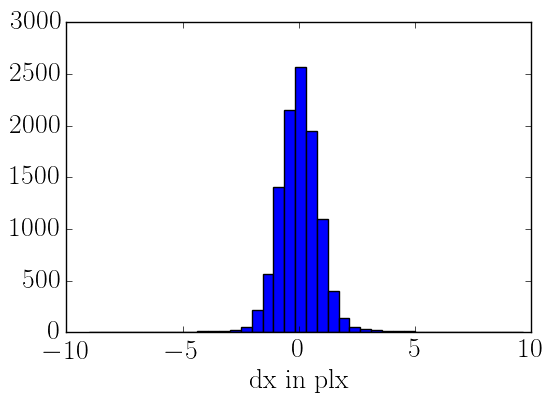

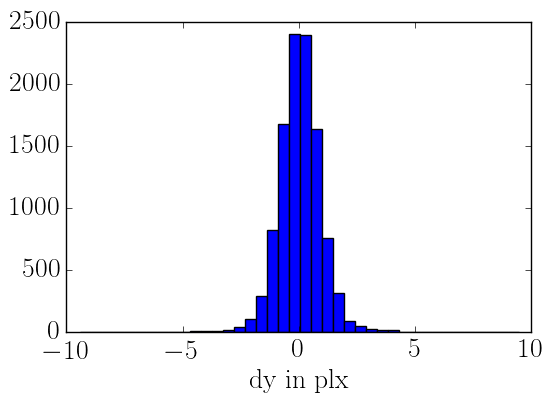

10790


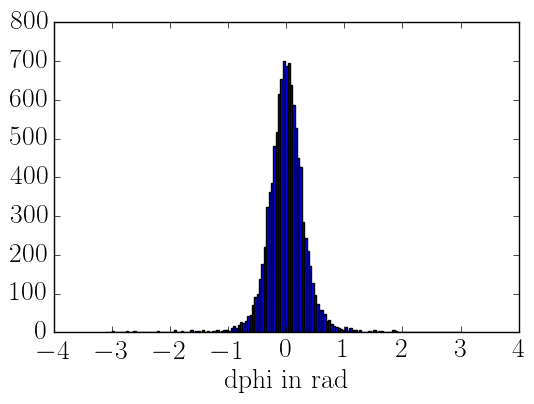

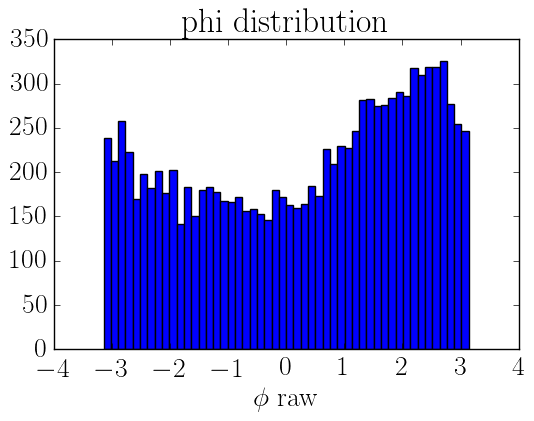

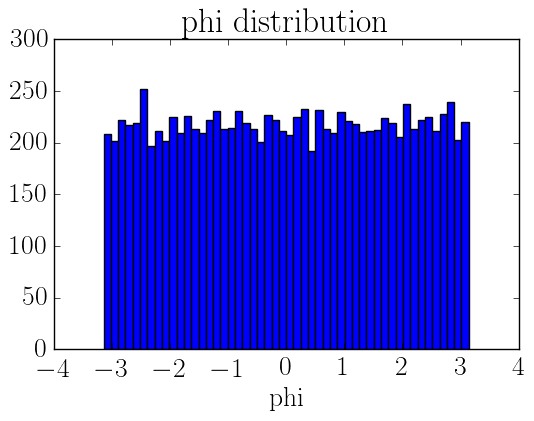

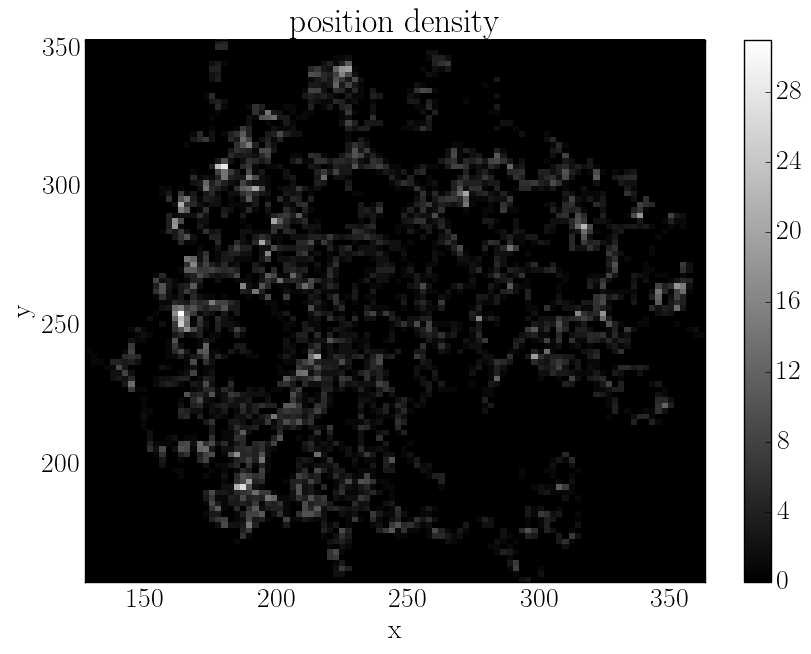

In [405]:
wdir = '.' # set the open file dialog directory to the notebook directory
def openFileDialog(wdir):
    from PyQt5.QtWidgets import QApplication,QFileDialog
    app = QApplication([dir])
    files = QFileDialog.getOpenFileNames(None, "Select Files...", wdir, filter="All Files (*)")
    return files[0]

def loadTDMS(file):
    global exposure, dimx, dimy
    tdms_file = TdmsFile(file)
    p=tdms_file.object().properties   
    dimx=int(p['dimx'])  
    dimy=int(p['dimy'])
    frames=int(int(p['dimz'])/nth)
    global frames_in_file; frames_in_file=frames
    exposure=float(p['exposure'])
    images=tdms_file.channel_data('Image','Image')
    frames = int(len(images)/dimx/dimy)
    #print('frames',frames)
    #print('dimx',dimx)
    #print('dimx_2',int(np.sqrt(len(images)/frames)))
    if dimx ==1:
        dimx = int(np.sqrt(len(images)/frames))
        dimy = dimx
    return images.reshape(frames,dimx,dimy)

######### ohter binsizes dont work yet!!!!
from copy import deepcopy
all_files = openFileDialog(wdir)
files = []
for file in all_files: # make the relevant file list
    if fnmatch.fnmatch(file,'*_movie.tdms'):
        files.append(file)
    
#min_max_coords = [[200,250],[200,250]]    

# specify all the relevant parameters
particle_radius = 7
cut_length_for_single = 9
box_radius = 130
nth = 1
exposuer_time = 0.03 #sec
global_TH = 1000

x_list = []
y_list = []
x_rel_list = []
y_rel_list = []
frame_list = []
file_list = []
udlr_list = []
phi_raw_list = []
phi_list = []
file_counter_list = []
frame_rel_list = []
master_index_list = []
nan_list = []
master_index = 0
cummulated_image = []
n = 0
problem_log = []
frame_tmp = 0

for file_number in range(len(files)):
    file = files[file_number]
    #print(file)
    series = np.zeros(0)
    if fnmatch.fnmatch(file,'*_movie.tdms'):
        series = loadTDMS(file)
        if n ==0:
            cummulated_image = np.array(series[0])
            for i in range(1,len(series)):
                cummulated_image += series[i]
        else:
            for i in range(len(series)):
                cummulated_image += series[i]
        n+=1
        tmp_single_paricles = np.array(Make_single_images_one_particle())
        
        if tmp_single_paricles != False:
            #####begin-------filter out all where there are >2 particle per frame------------------------
            if True:
                tmp_frame_list = tmp_single_paricles[:,2]  ##
                tmp_list2 = []  # i had to do this ugly and unsatisfieng thing becaus the tmp_frame_list has dtype object for uunkonwn reasons which cant be converted...
                for i in range(len(tmp_frame_list)):
                    tmp_list2.append(tmp_frame_list[i])
                bin_count = np.bincount(tmp_list2)
                tmp = 0
                indis=[]
                for i in range(len(bin_count)):
                    if bin_count[i] == 1:
                        tmp+=1
                        indis.append(True)
                    elif bin_count[i] >1:
                        for j in range(bin_count[i]):
                            indis.append(False)
                tmp_single_paricles = tmp_single_paricles[indis]
            #end--------------------------------------------------------------------------------
            #print(tmp_single_paricles)

            for i in range(len(tmp_single_paricles)):
                frame = tmp_single_paricles[i][2]
                x_rel,y_rel, phi = track_slice_1p(tmp_single_paricles[i][0],10,show = 'off')
                if phi > np.pi:
                    phi -= 2*np.pi
                if phi < -np.pi:
                    phi += 2*np.pi
                udlr = tmp_single_paricles[i][1]
                x = x_rel + udlr[2] #translate into original coords
                y = y_rel + udlr[1] #-"-
                x_list.append(x)
                y_list.append(y)
                frame_rel_list.append(frame)
                file_list.append(file)
                udlr_list.append(udlr)
                phi_raw_list.append(phi)
                phi_list.append(0)
                x_rel_list.append(x_rel)
                y_rel_list.append(y_rel)
                file_counter_list.append(file_number)
                frame_list.append(frame+frame_tmp) # here time delya betewwn frames could be added
                master_index_list.append(master_index)
                nan_list.append(np.nan)
                master_index += 1
                    #print('partner  ',master_index+1)
                #usefull_particle_images.append([tmp_single_double_paricles[i][0],[x_rel,y_rel,udlr_list,phi],frame,file])
        else:
            problem_log.append(file)
    frame_tmp += 300 + frames_in_file
    clear_output(wait=True)
    print('Progress1: File ',int(file_number)+1,' of ',int(len(files)))
#Tracked_particles = pd.DataFrame([x_list,y_list,phi_list,file_list,x_rel_list,y_rel_list,state_list,frame_list,file_counter_list]
#                                 ,index=pd.Series(range(len(x_list)))
#                                 ,columns = ['x','y','phi','file','x_rel','y_rel','state','frame','file_number']
#                                )


Tracked_particles = pd.DataFrame({'x' : x_list,
                                  'y' : y_list,
                                  'phi_raw' : phi_raw_list,
                                  'phi' : phi_list,
                                  'file' : file_list,
                                  'file_counter' : file_counter_list,
                                  'frame_rel' : frame_rel_list,
                                  'x_rel' : x_rel_list,
                                  'y_rel' : y_rel_list,
                                  'udlr' : udlr_list, 
                                  'frame' : frame_list,
                                  'master_index' : master_index_list,
                                   })
if len(problem_log) != 0:
    print('problems with files ', problem_log)
Tracked_particles.loc[:,'phi'] = Phi_calib(np.array(Tracked_particles.phi_raw),show=True)  #do the phi calib
Tracked_particles.to_csv('Tracked_particles.csv')
t = tp.link_df(Tracked_particles,10
               ,memory = 90);
t1 = tp.filter_stubs(Tracked_particles, 1)
t1.to_csv('t1.csv')
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', Tracked_particles['particle'].nunique())
print('After:', t1['particle'].nunique())
t1 = Compute_displacements()
t1.to_csv('t1.csv')
Plot_phi_raw_dist()
Plot_phi_dist()
Plot_position_desity()



In [449]:
exposure_time = 0.033
exposuer_time = 0.033
nth = 1

In [404]:
np.max(t1.frame)

299

In [406]:
t1.set_index(['master_index'],drop = False,inplace = True)

#WF_data = t1[(np.isfinite(np.array(t1['dx'])))
#                     & ((np.sqrt((np.array(t1['x'])-255)**2 + (np.array(t1['y'])-255)**2) < 80)
#                     | ((np.sqrt((np.array(t1['x'])-255)**2 + (np.array(t1['y'])-255)**2) > 115)
#                     & (np.sqrt((np.array(t1['x'])-255)**2 + (np.array(t1['y'])-255)**2) < 150))
#                        )
#                    ];

#diffu_data = t1[(np.isfinite(np.array(t1['x'])))
#                     & (np.sqrt((np.array(t1['x'])-255)**2 + (np.array(t1['y'])-255)**2) < 115)
#                     & (np.sqrt((np.array(t1['x'])-255)**2 + (np.array(t1['y'])-255)**2) > 80)
#                    ];


WF_data = t1[(np.sqrt((t1['x']-255)**2 + (t1['y']-255)**2) < 80)
                 & (np.isfinite(np.array(t1['x'])))    ## here all the nans are also filtered away   # look only for pairs
                    ];


t1_WF_newlylinked = tp.link_df(WF_data,5,memory = 5);

Frame 29577: 1 trajectories present


In [45]:
print(np.max(t1_WF_newlylinked.particle))
print(np.max(t1_WF_newlylinked.file_counter))

179.0
49


In [393]:
t1_WF_newlylinked.head()

,Unnamed: 0,file,file_counter,frame,frame_rel,master_index,phi,phi_raw,udlr,x,x_rel,y,y_rel,particle,dphi,dx,dy
0,0,//192.168.131.72/mona/Data/Nic/Messdaten/23012...,0,0,0,0,2.573513,2.607805,"[180, 154, 159, 185]",172.776923,13.776923,167.473077,13.473077,0.0,NaN,NaN,NaN
1,1,//192.168.131.72/mona/Data/Nic/Messdaten/23012...,0,1,1,1,2.532742,2.565593,"[180, 154, 158, 184]",171.442688,13.442688,167.865613,13.865613,0.0,-0.040770,-1.334235,0.392536
2,2,//192.168.131.72/mona/Data/Nic/Messdaten/23012...,0,2,2,2,2.637156,2.673698,"[183, 157, 158, 184]",171.704348,13.704348,170.152174,13.152174,0.0,0.104414,0.261660,2.286561
3,3,//192.168.131.72/mona/Data/Nic/Messdaten/23012...,0,3,3,3,2.779828,2.821414,"[184, 158, 156, 182]",169.585153,13.585153,171.410480,13.410480,0.0,0.142672,-2.119195,1.258306
4,4,//192.168.131.72/mona/Data/Nic/Messdaten/23012...,0,4,4,4,3.061671,3.102878,"[186, 160, 159, 185]",172.019685,13.019685,172.877953,12.877953,0.0,0.281843,2.434532,1.467472


In [407]:
t_to_use = t1_WF_newlylinked

In [10]:
t_to_use = t1

In [151]:
diffu_data = t1[(np.isfinite(np.array(t1['dx'])))
                     & (np.sqrt((np.array(t1['x'])-255)**2 + (np.array(t1['y'])-255)**2) < 105)
                     & (np.sqrt((np.array(t1['x'])-255)**2 + (np.array(t1['y'])-255)**2) > 85)
                    ];
t1_diffu_newlylinked = tp.link_df(diffu_data,15,memory = 1);
t_to_use = t1_diffu_newlylinked

Frame 37226: 1 trajectories present


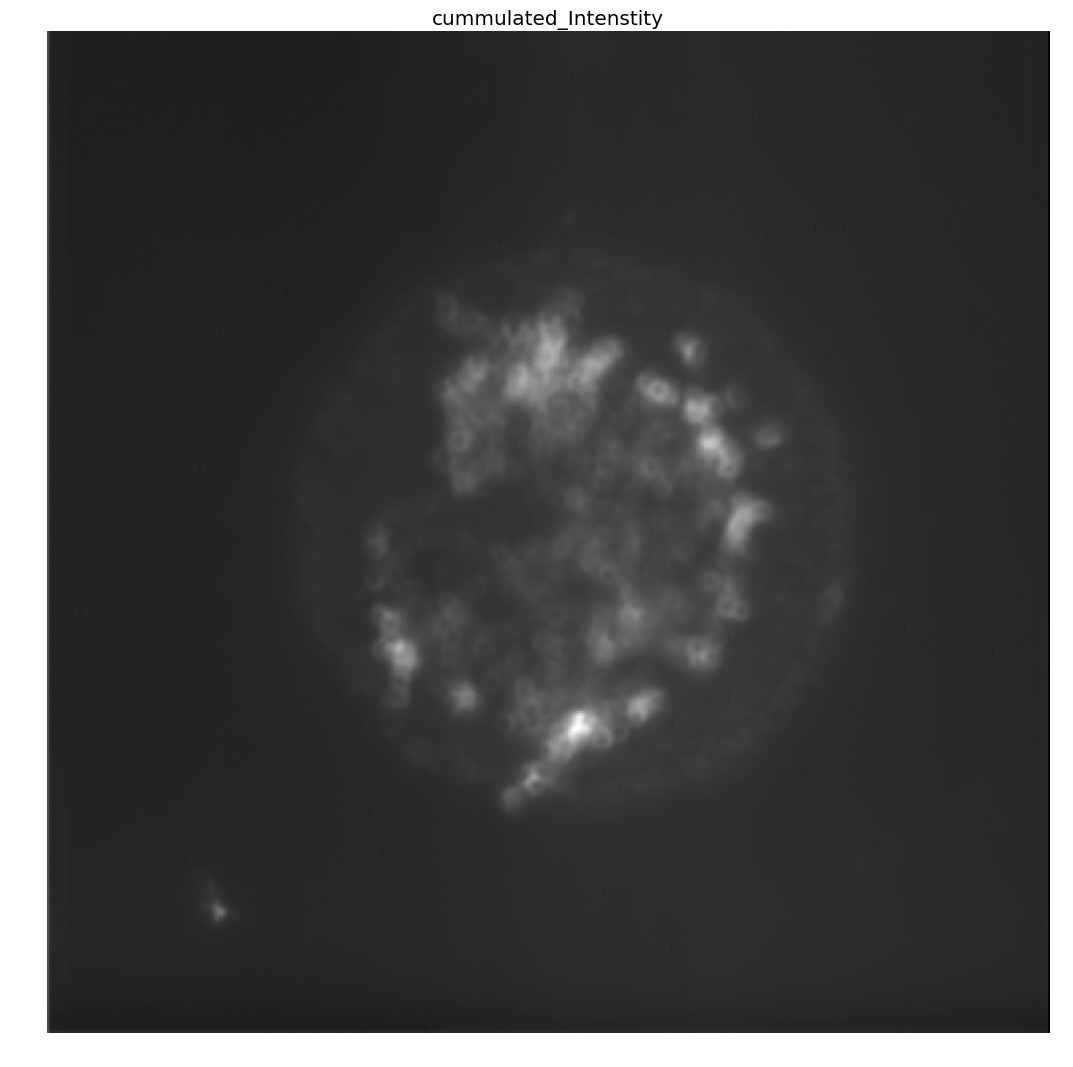

In [376]:
# safe and show cum image
def display_image_in_actual_size(image):
    dpi = 50
    height, width= image.shape
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)
    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    fig.patch.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    # Display the image.
    ax.imshow(image, cmap='gray',interpolation='none')
    plt.title('cummulated_Intenstity')
    plt.savefig('cummulated_Intensity.pdf')
    plt.show()
display_image_in_actual_size(cummulated_image)

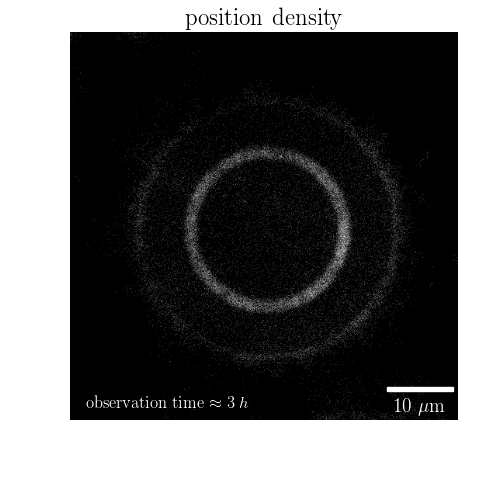

In [83]:

def Plot_position_desity1():
    t_to_use.set_index(['master_index'],drop = False,inplace = True)
    fig = plt.figure(figsize = (5,5))
    fig.patch.set_facecolor('white')
    plt.rc('font', **{'family': 'serif', 'serif': ['Helvetica'],'size':14})
    ax = fig.add_subplot(1, 1, 1)
    #plt.hist2d(t_to_use['x'],t_to_use['y'],cmap = 'gray',bins = 400)
    H, ex,ey = np.histogram2d(t_to_use['x'],t_to_use['y'],bins = 500)
    plt.imshow(np.sqrt(H+1),cmap = 'gray',)
    #plt.hist2d(t_to_use['x'],t_to_use['y'],cmap = 'gray',bins = 300)
    #circles(0, 0, 0.5, 'r', alpha=0.2, lw=5, edgecolor='b', transform=ax.transAxes)
    #ax.add_patch(plt.Circle((255, 255), 85, color='r', alpha=0.5))
    #ax.add_patch(plt.Circle((255, 255), 100, color='b', alpha=0.5))
    plt.title('position density')
    plt.xlabel('$x\;[\mu m]$')
    plt.ylabel('$x\;[\mu m]$')
    ax.text(0.25, 0.04,'observation time $ \\approx 3\; h$' ,
            color = 'white',
            fontsize = 12,
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    scalebar = ScaleBar(0.117,frameon=False,color = 'white',units = 'um',height_fraction = 0.01,pad = 0.1,location = 4) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    #plt.colorbar()
    plt.savefig('XYdensity_WF_arbit_scale.pdf')
    plt.show()
    return
Plot_position_desity1()

In [288]:
502-255

247

In [22]:
t_to_use.head()

,Unnamed: 0,file,file_counter,frame_rel,master_index,phi,phi_raw,udlr,x,x_rel,y,y_rel,dphi,dx,dy,frame,particle
master_index,,,,,,,,,,,,,,,,,


In [48]:
A = (150*0.117)**2*np.pi
26/A*1000

26.870096966026438

101 100


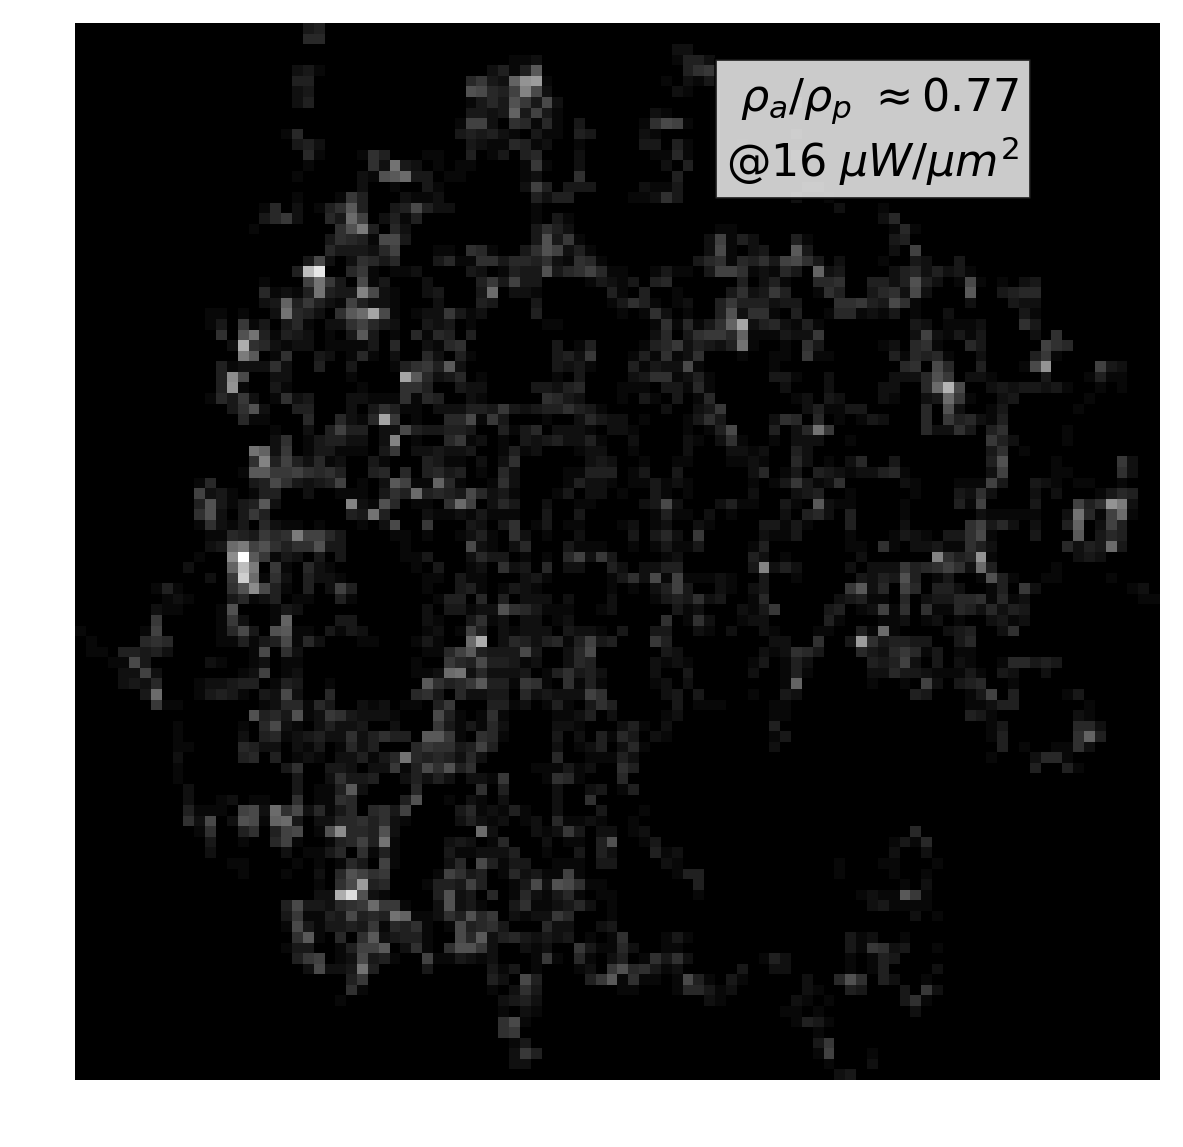

0.7735087271950812


In [27]:
def Calc_k():
    t_to_use.set_index(['master_index'],drop = False,inplace = True)
    H , xedges, yedges = np.histogram2d(t_to_use['x'],t_to_use['y'],bins = 100)     
    R1 = 28
    R2 = 33
    R3 = 85
    N_activ = 0
    A_activ = 0
    N_passiv = 0
    A_passiv = 0
    print(len(xedges),len(H))
    for i in range(len(xedges)-1):
        x = xedges[i]+(xedges[1]-xedges[0])/2-255
        for j in range(len(yedges)-1):
            y = yedges[j]+(yedges[1]-yedges[0])/2-255
            if np.sqrt(x**2+ y**2) < R1:
                N_passiv += H[i,j]
                A_passiv += 1
            elif np.sqrt(x**2+y**2) > R2 and np.sqrt(x**2+y**2) < R3:
                N_activ += H[i,j]
                A_activ += 1
    rho_passiv = N_passiv/A_passiv
    rho_activ = N_activ/A_activ
    fig = plt.figure(figsize = (7,7),dpi = 200)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    ax.hist2d(t_to_use['x']*0.117,t_to_use['y']*0.117,cmap = 'gray',bins = 100,
               label='k = '+str(format(rho_passiv/rho_activ, '.2g')))
    ax.text(0.6, 0.9,' $\\rho_{a} / \\rho_p$ $\\approx$' + str(format(rho_passiv/rho_activ, '.2g'))
            + '\n' +'@' + str(format(15/(150*0.117)**2/np.pi*1000, '.2g'))+ '$\; \mu W / \mu m^2$',
         horizontalalignment='left',
         verticalalignment='center',
         fontsize = 16,
         bbox=dict(facecolor='w', alpha=0.8),
         transform = ax.transAxes)
    plt.axis('off')
    plt.savefig('XYDensity_k.pdf')
    plt.show()
    print(rho_passiv/rho_activ)
    return
Calc_k()

In [365]:
file

'//192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole2/WF_ref_10mW/1JP_expo33_nth1_3151_movie.tdms'

In [42]:
file

'//192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole/hole_r30_rWF90_26mW/1JP_expo33_nth1_WF26mW_rWF120_475_movie.tdms'

In [15]:
np.histogram2d?

In [1]:
# plot and fit dphi
def Plot_dphi(logy='off',dt=1):
    #t1.set_index(['master_index'],drop = False,inplace = True)    # some other filtering
    #t1_filtered = t1[(np.isfinite(np.array(t1[quantity])))
    #                 & (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 150)
    #                ];
    #print(np.sum(np.isfinite(np.array(t1_filtered[quantity]))))
    #data = np.array(t1_filtered[quantity])
    
    #data = np.array(t_to_use['dphi'][np.isfinite(t_to_use['dphi'])])  # use the set filtering and dt =1
    
    t1_filtered = t_to_use
    #t1_filtered = t1
    dphi_list = np.zeros(len(t1_filtered['phi']))  # arbit dt and set filtering
    N = 0
    #dt = 1
    n=0
    for  pid, ptraj in t1_filtered.groupby('particle'):
        if len(ptraj.phi)>dt:
            phi_data = (np.array(ptraj.phi))
            dphi = (phi_data[dt:]-phi_data[:-dt])
            dphi[dphi<-np.pi] += 2*np.pi
            dphi[dphi>np.pi] += -2*np.pi
            dphi_list[n:n+len(dphi)] = dphi
            n += len(dphi)
            N+=n
    data = dphi_list[dphi_list!=0]
    N = len(data)
    
    print(N)
    n_bins = 100
    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
    bin_centres = bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2
    
    # Define model function to be used to fit to the data above:
    #def gauss(phi, *p):
    #    A, mu, sigma = p
    #    value = 0
    #    mirror_list = [-3,-2,-1,0,1,2,3]
    #    for i in mirror_list:
    #        value += A*np.exp(-(phi+i*2*np.pi)**2/(4D))
    #    return value
    
    
    def gauss(x, *p):
        #A, sigma = p
        A, D = p
        #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        value = 0
        mirror_list = [-3,-2,-1,0,1,2,3]
        for i in mirror_list:
            value += A/np.sqrt(np.pi*4*D*dt*exposuer_time*nth)*np.exp(-(x+2*np.pi*i)**2/(4*D*dt*exposuer_time*nth))
        return value
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    
    
    def dphi_dist2(phi,*p):
        A, sigma  = p
        A = 1                                      
        #sigma = 0.1
        N = 20
        theta_range = np.linspace(1,N,N)/(N+1)*np.pi
        dtheta = 2*np.pi/(N+1)
        value = 0
        mirror_list = [-3,-2,-1,0,1,2,3]
        for theta in theta_range:
            for i in mirror_list: # this is for large delta ts, dont know if thi is ok, but you know who cares... (no rly i think its ok)
                value += 1/4/np.sqrt(2*np.pi*sigma**2) * np.sin(theta)**2* np.exp(-(phi+i*2*np.pi)**2*np.sin(theta)**2 / (2.*sigma**2))*dtheta
            ## the 1/4 should be 1/2 theoretically but it turns out htat the normalisaiton demands 1/4...
        return value
    p1 = [1,1]
    
    
    p0 = [1, 0.1]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    coeff2, var_matrix = curve_fit(dphi_dist2, bin_centres, hist, p0=p1)
    D_r_gauß = coeff[1]  # write the mean innto the matrix
    
    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    hist_fit = gauss(bin_centres, *coeff)
    hist_fit2 = dphi_dist2(bin_centres,*coeff2)
    
    bin_size = bin_edges[1]-bin_edges[0]
    bin_edges_mid = np.array(bin_edges)+bin_size/2
    bin_edges_mid = list(bin_edges_mid)
    bin_edges_mid.pop()
    #ax.scatter(bin_edges_mid, hist)
    if logy == 'on':
        ax.semilogy(bin_edges_mid, hist,label = 'data',color='black')
        ax.semilogy(bin_centres, hist_fit, label='gauss fit',color='blue')
        ax.semilogy(bin_centres, hist_fit2, label='3D rot fit',color='red')
        plt.xlim(np.min(data),np.max(data))
        plt.ylim(ymin=10**-4)
    else: 
        ax.plot(bin_centres, hist_fit, label='gauss fit',color='blue')
        ax.hist(data,bins = n_bins,normed=True, color = 'white', ec="black")
        ax.plot(bin_centres, hist_fit2, label = '3D rot fit',color='red')
    print('newfit has param:',coeff2)
    ax.legend(fontsize=14)
    #ax.grid()
    print(coeff2[1]**2/2/0.04)
    print(coeff2[1])
    print(0.22**2/2/0.03)
    print('d_r', coeff2[1]**2/2/exposure_time/nth/dt)
    
    ax.text(0.65, 0.75,'(3D rot fit) $D_r$ =  '+str(format(coeff2[1]**2/2/exposure_time/nth/dt, '.2g')) + '$s^{-1}$'
            + '\n' + '(Gauss) $D_r$ =  '+str(format(D_r_gauß, '.2g')) + '$s^{-1}$'
            + '\n' + '$dt$ =  '+str(format(dt*exposuer_time, '.2g')) + '$s$',
         fontsize=14,
         horizontalalignment='left',
         verticalalignment='center',
         bbox=dict(facecolor='w', alpha=1),
         transform = ax.transAxes)
    ax.set_xlim(xmin = np.min[hist[hist!=0]])
    plt.xlabel('$d \phi$') 
    plt.title('$d\phi$'+ ' hist')
    if logy == 'on':
        plt.savefig('dphi_hist_logy_active_dt'+str(int(dt))+ '.pdf')
    else:
        plt.savefig('dphi_hist_avtive_dt' +str(int(dt))+ '.pdf')
    fig.show()
    return

#Plot_dphi(logy='off')
Plot_dphi(logy='on',dt=1)
Plot_dphi(logy='on',dt=2)
Plot_dphi(logy='on',dt=4)

NameError: name 't_to_use' is not defined

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


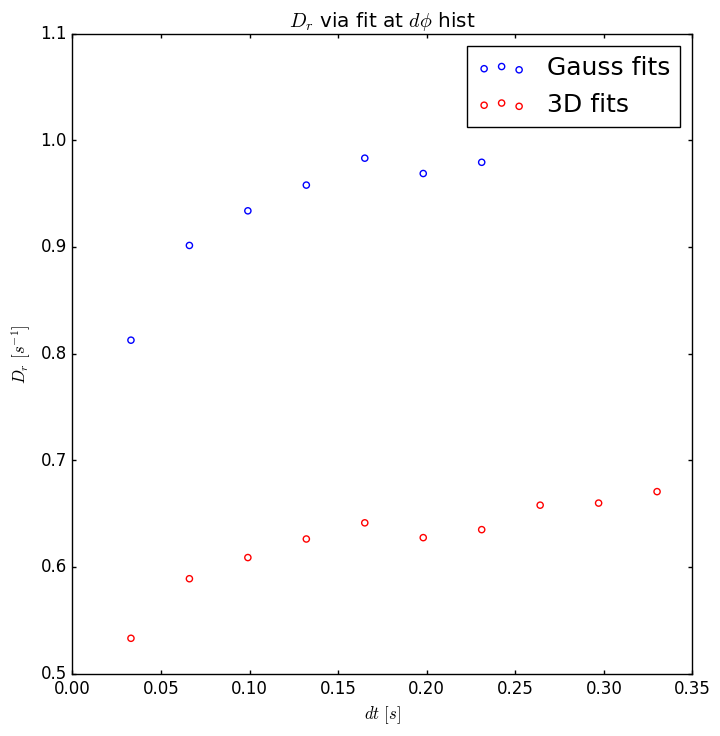

In [231]:
def Plot_Dr_of_dt_via_dphi_hist():
    t1.set_index(['master_index'],drop = False,inplace = True)
    #t1_filtered = t1[(np.isfinite(np.array(t1['dy'])))
    #                ];
    t1_filtered = t1[(np.isfinite(np.array(t1['dx'])))
                     & (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 400)
                    ];
    #print(np.sum(np.isfinite(np.array(t1_filtered[quantity]))))
    #data = np.array(t1_filtered['dy'])
    
    t1_filtered = t_to_use
    #dphi_list = np.zeros(len(t1_filtered['x']))
    
    #N = 0
    max_dt = int(3/exposuer_time)
    max_dt = 10
    dt_list = np.linspace(1,max_dt,max_dt).astype('int')
    Dr_list_gauß = np.zeros(len(dt_list))
    Dr_list_3D = np.zeros(len(dt_list))
    for i in range(len(dt_list)):
        dt = dt_list[i]
        n = 0
        dphi_list = np.zeros(len(t1_filtered['x']))
        for  pid, ptraj in t1_filtered.groupby('particle'):
            if len(ptraj.x)>dt:
                phi_data = (np.array(ptraj.phi))
                dphi = (phi_data[dt:]-phi_data[:-dt])
                dphi[dphi<-np.pi] += 2*np.pi
                dphi[dphi>np.pi] += -2*np.pi
                dphi_list[n:n+len(dphi)] = dphi
                n += len(dphi)
        data = dphi_list[dphi_list!=0]
        N = len(data)
        n_bins = 80
        hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        
        def gauss(x, *p):
            #A, sigma = p
            A, D = p
            #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
            value = 0
            mirror_list = [-3,-2,-1,0,1,2,3]
            for i in mirror_list:
                value += A/np.sqrt(np.pi*4*D*dt*exposuer_time*nth)*np.exp(-(x+2*np.pi*i)**2/(4*D*dt*exposuer_time*nth))
            return value
        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)


        def dphi_dist2(phi,*p):
            A, sigma  = p
            #A = 1                                      
            #sigma = 0.1
            N = 40
            theta_range = np.linspace(1,N,N)/(N+1)*np.pi
            dtheta = 2*np.pi/(N+1)
            value = 0
            mirror_list = [-3,-2,-1,0,1,2,3]
            for theta in theta_range:
                for i in mirror_list: # this is for large delta ts, dont know if thi is ok, but you know who cares... (no rly i think its ok)
                    value += 1/4/np.sqrt(2*np.pi*sigma**2) * np.sin(theta)**2* np.exp(-(phi+i*2*np.pi)**2*np.sin(theta)**2 / (2.*sigma**2))*dtheta
                ## the 1/4 should be 1/2 theoretically but it turns out htat the normalisaiton demands 1/4...
            return A*value
        p1 = [1,1]
        p0 = [1, 0.1]
        coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
        coeff2, var_matrix = curve_fit(dphi_dist2, bin_centres, hist, p0=p1)
        D_r_gauß = coeff[1]

        Dr_list_gauß[i] = D_r_gauß
        Dr_list_3D[i] = coeff2[1]**2/2/exposure_time/nth/dt
        #print(coeff2[1]**2/2/exposure_time/nth/dt)
        #print('Dr_gauß',D_r_gauß)
    
    fig = plt.figure(figsize=(8, 8),dpi = 300)
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(dt_list*exposuer_time, Dr_list_gauß,color='blue',label='Gauss fits',facecolors='none',)
    ax.scatter(dt_list*exposuer_time, Dr_list_3D,color='red',label='3D fits',facecolors='none')
    ax.legend(fontsize=18)
    #ax.set_xscale("log", nonposx='clip')
    #ax.grid(which='both')
    fig.patch.set_facecolor('white')
    #ax.set_xlim(left = -5, right = 5)
    plt.title('$D_r$ via fit at $d\phi$ hist')
    plt.xlabel('$dt$ $[s]$')
    plt.ylabel('$D_r$ $[s^{-1}]$')
    ax.tick_params(axis= 'both',direction='in', length=3, width=1, colors='black')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.savefig('Dr_via_dphi_hist.pdf')
    fig.show()
    return
Plot_Dr_of_dt_via_dphi_hist()

In [306]:
file

'//192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole2/hole_25mW_rWF90_r30/1JP_expo33_nth10_2005_movie.tdms'

In [194]:
t1.file[0]

'//192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole2/diff_ref_zwischendrin/1JP_expo33_nth1_3152_movie.tdms'

0.7328285309575265


C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


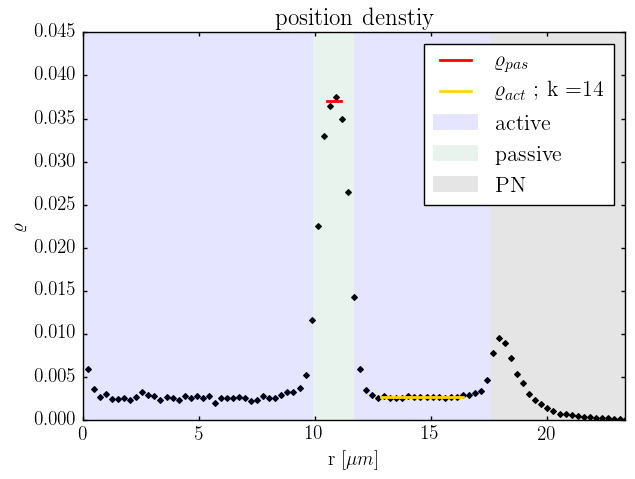

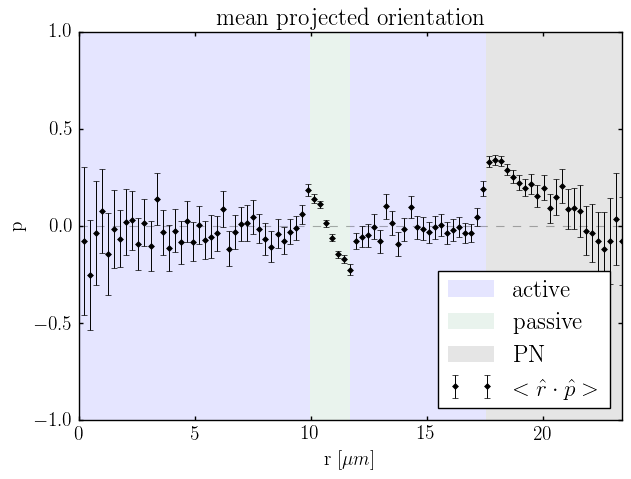

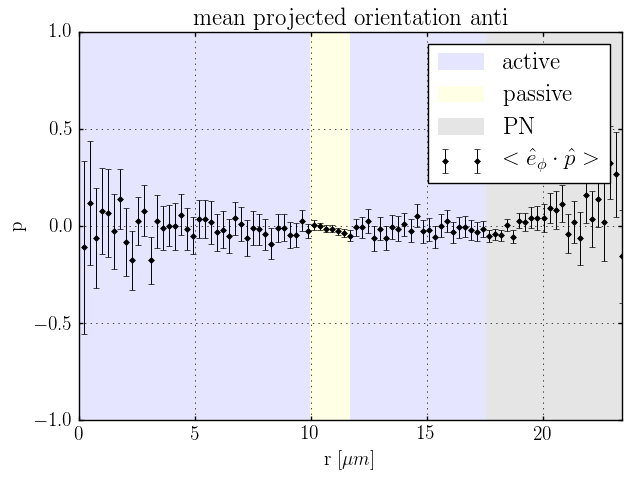

In [142]:
#### tho mean orientaion:
def Plot_mean_orientation_projection(dataframe):
    t1.set_index(['master_index'],drop = False,inplace = True)
    #WF_data = t1[(np.sqrt((t1['x'] - hole_x)**2 + np.sqrt(t1['y']-hole_y)**2) > hole_radius)
                     #& (np.sqrt((t1['x'] - center)**2 + np.sqrt(t1['y']-center)**2) < PN_radius-PN_buffer) # here a small spatial buffer is used to realy ignor all PN data
                     #& (np.isfinite(np.array(t1['x'])))    ## here all the nans are also filtered away   # look only for pairs
                        #];
    Nbins = 150
    x_list = np.array(t1.x)-255
    y_list = np.array(t1.y)-255
    r_list = np.sqrt(x_list**2 + y_list**2)
    weight_list = 1/r_list
    phi_list = np.array(t1.phi_raw)
    p_list = (x_list*np.sin(phi_list) + y_list*np.cos(phi_list))/r_list# p is the mean projected orientation
    p_list_anti = (y_list*np.sin(phi_list) + x_list*np.cos(phi_list))/r_list# p is the mean projected orientation
    H, redges = np.histogram(r_list,bins=Nbins,normed=True,weights=weight_list)
    print(redges[0])
    r_mids = redges[:-1]+ 0.5*(redges[1]-redges[0])
    H_o = np.zeros(len(H))
    H_o_anti = np.zeros(len(H))
    H_o_uncert = np.zeros(len(H))
    H_o_uncert_anti = np.zeros(len(H))
    
    r1 = 85
    r2 = 100
    r3 = 150
    
    for i in range(len(H)):
        H_o[i] = np.mean(p_list[(r_list > redges[i])&(r_list < redges[i+1])])
        H_o_anti[i] = np.mean(p_list_anti[(r_list > redges[i])&(r_list < redges[i+1])])
        N = len(p_list[(r_list > redges[i])&(r_list < redges[i+1])])
        H_o_uncert[i] = np.std(p_list[(r_list > redges[i])&(r_list < redges[i+1])])/np.sqrt(N)* stats.t.ppf(0.95,N)
        H_o_uncert_anti[i] = np.std(p_list_anti[(r_list > redges[i])&(r_list < redges[i+1])])/np.sqrt(N)* stats.t.ppf(0.95,N)
    
    passive_indis = (r_mids > r1+5) & (r_mids < r2-5) 
    active_indis = (r_mids > r2+10) & (r_mids < r3-10)
    
    rho_passive = np.sum(H[passive_indis]*r_mids[passive_indis])/np.sum(r_mids[passive_indis]) 
    rho_active = np.sum(H[active_indis]*r_mids[active_indis])/np.sum(r_mids[active_indis])
    #print('$r_{active}$ ; k =' +str(format(rho_passive/rho_active, '.2g')))
    
    r1 = r1*0.117
    r2 = r2*0.117
    r3 = r3*0.117
    
    
    
    fig = plt.figure(figsize=(7, 5),dpi = 300)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    #ax.grid()
    plt.title('position denstiy')
    ax.plot(np.array([r1+5*0.117,r2-5*0.117]),[rho_passive,rho_passive], linewidth=2, color='r',label = '$\\varrho_{pas}$')
    ax.plot(np.array([r2+10*0.117,r3-10*0.117]),[rho_active,rho_active], linewidth=2, color='gold',label = '$\\varrho_{act}$ ; k =' +str(format(rho_passive/rho_active, '.2g')))
    plt.ylabel('$\\varrho$')
    plt.xlabel('r $[\mu m]$')
    import matplotlib.transforms as mtransforms
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    plt.fill([0,r1,r1,0], [0,0,1.2*np.max(H),1.2*np.max(H)], 'blue', alpha=0.1, edgecolor='b',lw=0,label= 'active')
    plt.fill([r1,r2,r2,r1], [0,0,1.2*np.max(H),1.2*np.max(H)], 'seagreen', alpha=0.1, edgecolor='r',lw=0,label = 'passive')
    plt.fill([r2,r3,r3,r2], [0,0,1.2*np.max(H),1.2*np.max(H)], 'blue', alpha=0.1, edgecolor='green',lw=0)
    plt.fill([r3,255*0.117,255*0.117,r3], [0,0,1.2*np.max(H),1.2*np.max(H)], 'black', alpha=0.1, edgecolor='r',lw=0,label = 'PN')
    ax.set_ylim(ymin = 0)
#    ax.set_ylim((0,300))
    ax.set_xlim((0,200*0.117))
    #ax.hist(r_list, bins=redges,weights=weight_list,normed=True,label = 'normalized particle count',alpha = 1,color='black')
    ax.tick_params(axis= 'both',direction='in', length=3, width=1, colors='black')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.scatter(r_mids*0.117, H,marker='D',facecolor = 'k', edgecolor = 'k',s=8)
    
    #ax.hist(r_list*0.117,bins=Nbins,normed=True,weights=weight_list, color = 'white', ec="black")
    #ax.scatter(r_mids,H,marker = '+',color='black',s = 30,lw = 1,label = 'normalized particle count')
    #ax.tick_params(axis='both',which='major',length=8,width=2,labelsize=18)
    #ax.tick_params(axis='y', which='both', labelleft='off', labelright='on')
    plt.legend(prop={'size': 16})
    #plt.legend()
    plt.savefig('r_hist.pdf')
    plt.show()
    
    fig = plt.figure(figsize=(7, 5),dpi = 300)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    #plt.grid()
    plt.title('mean projected orientation')
    #plt.scatter(r_mids,H_o,marker = '+',s = 30,lw = 1)
    plt.errorbar(r_mids*0.117,-H_o,yerr=H_o_uncert,label='$<\hat{r} \cdot \hat{p}>$',xerr = None,fmt='D',markersize = '3',color='black', elinewidth=0.7, capsize=2, barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, hold=None, data=None)
    #plt.scatter(r_mids,H_o)
    #plt.axhline(y=0, xmin=0, xmax=np.max(r_mids), linewidth=0.3, color = 'k')
    plt.xlabel('r $[\mu m]$')
    plt.fill([0,r1,r1,0], [-1,-1,1,1], 'b', alpha=0.1, edgecolor='b',lw=0,label= 'active')
    plt.fill([r1,r2,r2,r1], [-1,-1,1,1], 'seagreen', alpha=0.1, edgecolor='seagreen',lw=0,label = 'passive')
    plt.fill([r2,r3,r3,r2], [-1,-1,1,1], 'b', alpha=0.1, edgecolor='b',lw=0)
    plt.fill([r3,np.max(r_mids)*0.117,np.max(r_mids)*0.117,r3], [-1,-1,1,1], 'black', alpha=0.1, edgecolor='r',lw=0,label = 'PN')
    #plt.axvline(x=150, ymin=0, ymax = 1, linewidth=0.5, color='b',label = '$r_{PN}$')
    ax.plot([0,255*0.117],[0,0],ls = '--',alpha = 0.3,color = 'k',lw = 0.8)
    ax.tick_params(axis= 'both',direction='in', length=3, width=1, colors='black')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.ylim(ymin = -1, ymax = 1)
    plt.xlim(xmin = 0,xmax=200*0.117)
    plt.legend(loc = 4)
    plt.ylabel('p')
    plt.savefig('orient_r_hist.pdf')
    plt.show()
    
    fig = plt.figure(figsize=(7, 5),dpi = 300)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    plt.grid()
    plt.title('mean projected orientation anti')
    #plt.scatter(r_mids,H_o_anti,marker = '+',s = 30,lw = 1)
    plt.errorbar(r_mids*0.117,H_o_anti,yerr=H_o_uncert_anti,label='$<\hat{e}_{\phi} \cdot \hat{p}>$',xerr = None,fmt='D', markersize=3,color='black',elinewidth=0.7, capsize=2,barsabove=False, lolims=False, uplims=False, xlolims=False, xuplims=False, errorevery=1, capthick=None, hold=None, data=None)
    #plt.axhline(y=0, xmin=0, xmax=np.max(r_mids), linewidth=0.3, color = 'k')
    plt.xlabel('r $[\mu m]$')
    plt.fill([0,r1,r1,0], [-1,-1,1,1], 'b', alpha=0.1, edgecolor='b',lw=0,label= 'active')
    plt.fill([r1,r2,r2,r1], [-1,-1,1,1], 'yellow', alpha=0.1, edgecolor='yellow',lw=0,label = 'passive')
    plt.fill([r2,r3,r3,r2], [-1,-1,1,1], 'b', alpha=0.1, edgecolor='b',lw=0)
    plt.fill([r3,np.max(r_mids)*0.117,np.max(r_mids*0.117),r3], [-1,-1,1,1], 'black', alpha=0.1, edgecolor='r',lw=0,label = 'PN')
    ax.tick_params(axis= 'both',direction='in', length=3, width=1, colors='black')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    #plt.axvline(x=150, ymin=0, ymax = 1, linewidth=0.5, color='b',label = '$r_{PN}$')
    plt.ylim(ymin = -1, ymax = 1)
    plt.xlim(xmin = 0,xmax=200*0.117)
    plt.legend()
    plt.ylabel('p')
    plt.savefig('orient_r_hist_anti.pdf')
    plt.show()
    
    return 
Plot_mean_orientation_projection(t1)



In [203]:
scipy.optimize.differential_evolution?

In [139]:
np.sqrt(6.52/0.14)

6.824326235712106

In [235]:
file

'//192.168.131.72/mona/Data/Nic/Messdaten/23012018_circ_density/Phi_calib_2/1JP_529_movie.tdms'

In [ ]:
from matplotlib import pyplot as plt
import numpy


x=numpy.array([1,2,3,4,5])
y=numpy.array([5,4,7,1,7])

plt.plot(x,y,'ok')
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


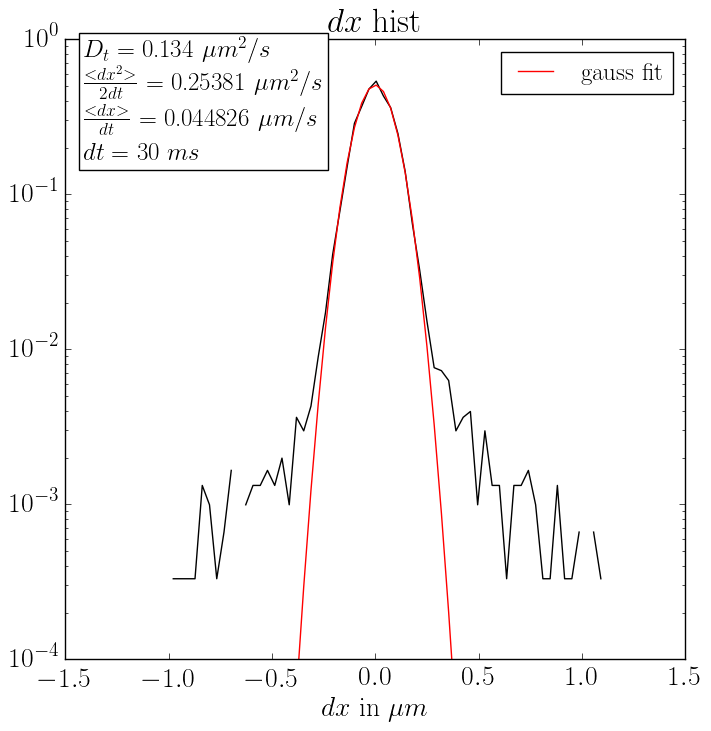

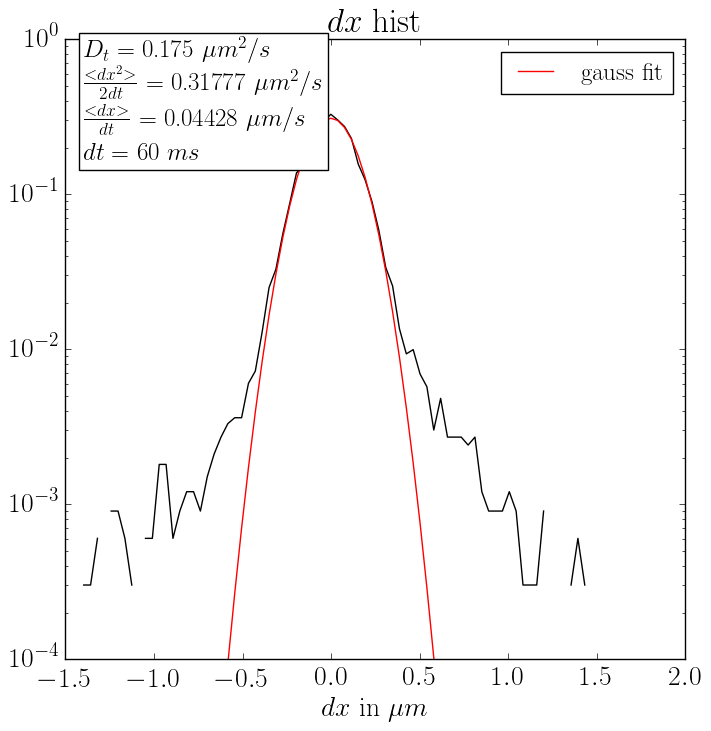

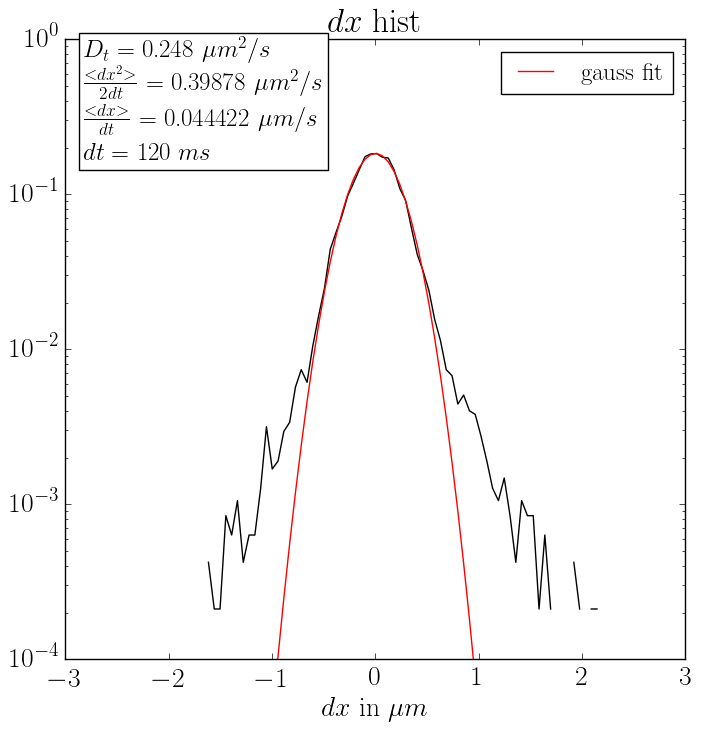

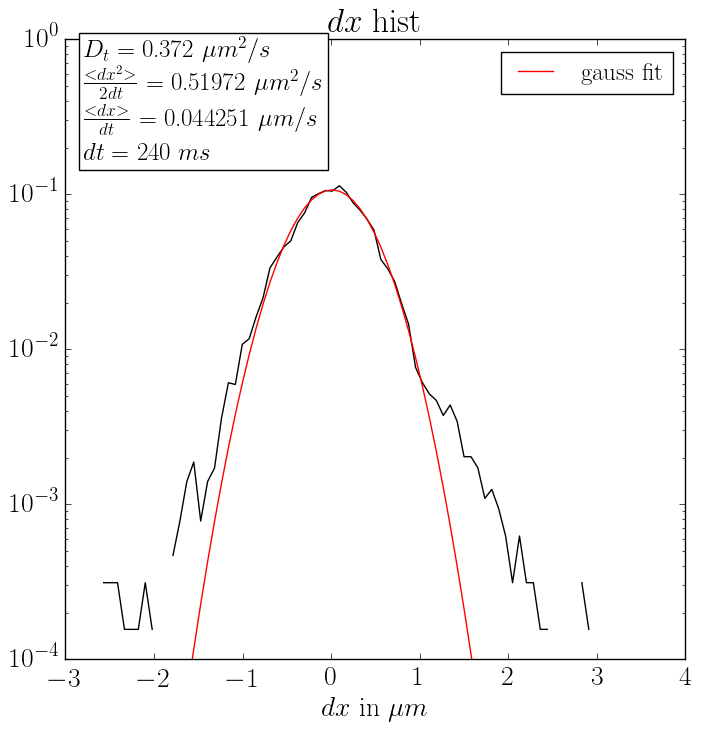

In [384]:
def Plot_dx(logy='off',dt=1):
    t1.set_index(['master_index'],drop = False,inplace = True)
    #t1_filtered = t1[(np.isfinite(np.array(t1['dy'])))
    #                ];
    t1_filtered = t_to_use
    t1_filtered = t1[(np.isfinite(np.array(t1['dx'])))
                     & (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 400)
                    ];
    #print(np.sum(np.isfinite(np.array(t1_filtered[quantity]))))
    #data = np.array(t1_filtered['dy'])
    
    dx_list = np.zeros(len(t1_filtered['x']))
    #N = 0
    #dt =1
    n = 0
    for  pid, ptraj in t1_filtered.groupby('particle'):
        if len(ptraj.x)>dt:
            x_data = (np.array(ptraj.x))
            y_data = (np.array(ptraj.y))
            dx = (x_data[dt:]-x_data[:-dt])
            dy = (y_data[dt:]-y_data[:-dt])
            dx_list[n:n+len(dx)] = dx
            n += len(dx)
    data = dx_list[dx_list!=0]
    N = len(data)
    n_bins = 80
    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        A, mu, D = p
        #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        return A/np.sqrt(np.pi*4*D*dt*exposuer_time*nth)*np.exp(-(x-mu)**2/(4*D*dt*exposuer_time*nth))
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p1 = [1,1]
    
    
    p0 = [0., 0.1, 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    #coeff2, var_matrix = curve_fit(dphi_dist2, bin_centres, hist, p0=p1)
    mean = coeff[1]  # write the mean innto the matrix
    D = np.abs(coeff[2])
    uncert = np.abs(var_matrix[1,1])
    dx0_simple = np.mean(data)*0.117/dt/exposuer_time
    uncert_mean = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
    D_simple = np.var(data)*0.117**2/dt/exposuer_time/2
    
    
    
    fig = plt.figure(figsize=(8, 8),dpi = 300)
    
    ax = fig.add_subplot(1, 1, 1)
    hist_fit = gauss(bin_centres, *coeff)
    #hist_fit2 = dphi_dist2(bin_centres,*coeff2)
    
    bin_size = bin_edges[1]-bin_edges[0]
    bin_edges_mid = np.array(bin_edges)+bin_size/2
    bin_edges_mid = list(bin_edges_mid)
    bin_edges_mid.pop()
    #ax.scatter(bin_edges_mid, hist)
    if logy == 'on':
        ax.semilogy(np.array(bin_edges_mid)*0.117, hist,color = 'black')
        ax.semilogy(bin_centres*0.117, hist_fit, label='gauss fit', color = 'red')
        #plt.xlim(np.min(data),np.max(data))
        plt.ylim(ymin=10**-4)
    else: 
        ax.plot(bin_centres*0.117, hist_fit/0.117, label='gauss fit',color = 'red')
        ax.hist(data*0.117,bins = n_bins,normed=True, color = 'white', ec="black")
        #ax.plot(bin_centres, hist_fit2, label = '3D rot fit')
    ax.legend(fontsize=18)
    #ax.grid(which='both')
    fig.patch.set_facecolor('white')
    #ax.set_xlim(left = -5, right = 5)
    plt.title('$dx$'+ ' hist')
    ax.text(0.03, 0.9,#' $\sigma$ =' + str(format(std*0.117, '.3g'))+ ' $\mu m$  ;  '  
            #+ '$D_t$ =  '+str(format(std**2/2/exposure_time*0.117**2/nth/dt, '.2g')) + ' $\mu m^2/s$'  ,
             '$D_t =$  '+str(format(D*0.117**2, '.3g')) + ' $\mu m^2/s$'
            + '\n'+ '$ \\frac{<dx^2>}{2dt}$  = '+str(format(D_simple, '.5g')) + ' $\mu m^2/s$'
            + '\n'+ '$ \\frac{<dx>}{dt}$  = '+str(format(dx0_simple, '.5g')) + ' $\mu m/s$'
            + '\n' + '$dt = $ '+ str(format(dt*exposuer_time*nth*1000, '.3g')) + ' $ms$',
            fontsize=18,
         horizontalalignment='left',
         verticalalignment='center',
         bbox=dict(facecolor='w', alpha=1),
         transform = ax.transAxes)
    plt.xlabel('$dx$ in $\mu m$')

    if logy == 'on':
        plt.savefig('dx_hist_logy_active'+str(int(dt))+ '.pdf')
    else:
        plt.savefig('dx'+'_hist_active'+str(int(dt))+'.pdf')
    fig.show()
    return

Plot_dx(logy='on',dt=1)
Plot_dx(logy='on',dt=2)
Plot_dx(logy='on',dt=4)
Plot_dx(logy='on',dt=8)



#Plot_dx(logy='off')
#Plot_quantity('dphi',logy='on')


C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


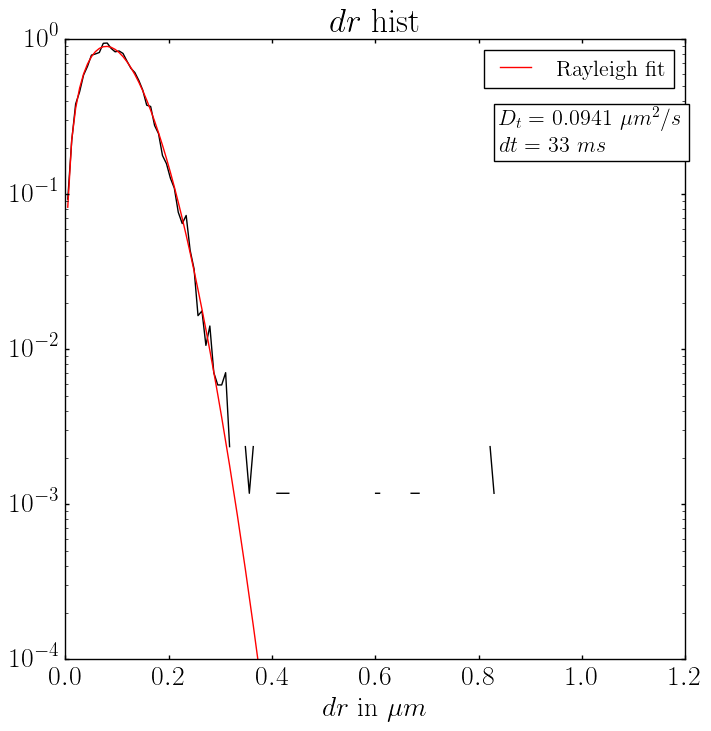

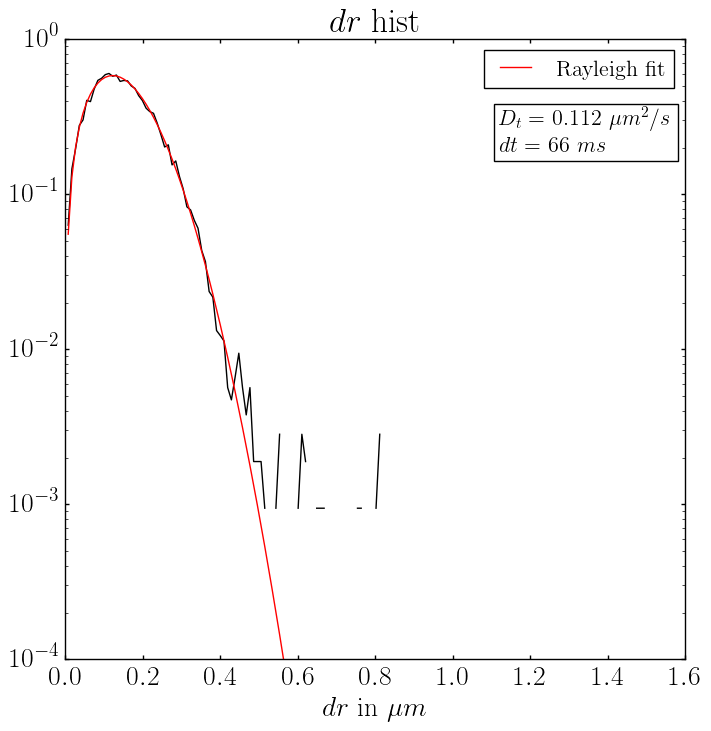

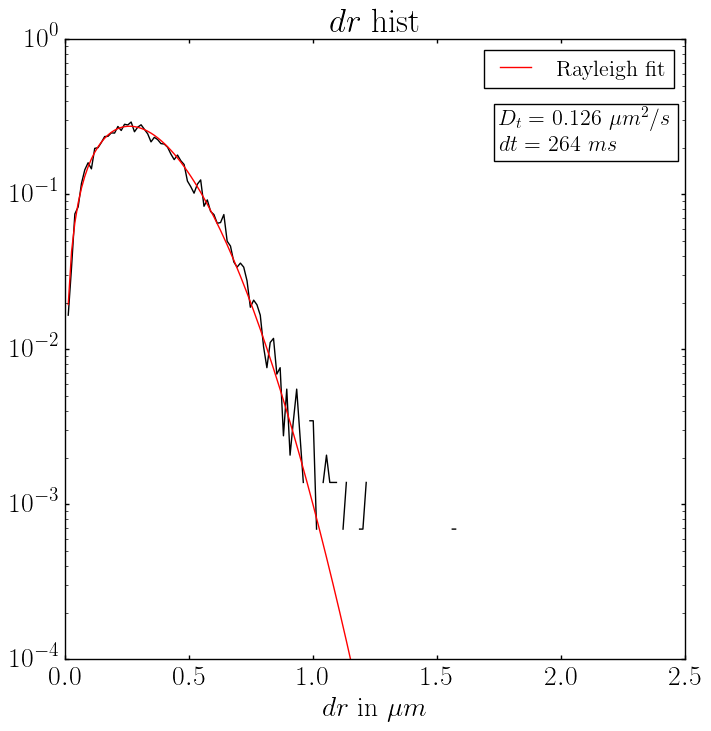

In [450]:
def Plot_dr(logy='off',dt = 1):
    t1.set_index(['master_index'],drop = False,inplace = True)
    #t1_filtered = t1[(np.isfinite(np.array(t1['dy'])))
    #                ];
    t1_filtered = t1[(np.isfinite(np.array(t1['dx'])))
                     & (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 400)
                    ];
    #print(np.sum(np.isfinite(np.array(t1_filtered[quantity]))))
    #data = np.array(t1_filtered['dy'])
    
    dx_list = np.zeros(len(t1_filtered['x']))
    dy_list = np.zeros(len(t1_filtered['x']))
    dr_list = np.zeros(len(t1_filtered['x']))
    #N = 0
    #dt =1
    n = 0
    for  pid, ptraj in t1_filtered.groupby('particle'):
        if len(ptraj.x)>dt:
            x_data = (np.array(ptraj.x))
            y_data = (np.array(ptraj.y))
            dx = (x_data[dt:]-x_data[:-dt])
            dy = (y_data[dt:]-y_data[:-dt])
            dx_list[n:n+len(dx)] = dx
            dy_list[n:n+len(dx)] = dy
            dr_list[n:n+len(dx)] = np.sqrt(dx**2+dy**2)
            n += len(dx)
    data = dr_list[dx_list!=0]
    N = len(data)
    n_bins = 150
    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        A, mu, D = p
        #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        return A/np.sqrt(np.pi*4*D*dt*exposuer_time*nth)*np.exp(-(x-mu)**2/(4*D*dt*exposuer_time*nth))
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    
    def rayleigh(x,*p):
        A, D = p
        return 2*x/(4*D*dt*exposuer_time*nth)*np.exp(-x**2/(4*D*dt*exposuer_time*nth))
    
    def dphi_dist2(phi,*p):
        A, sigma  = p
        #A = 1                                      
        #sigma = 0.1
        N = 20
        theta_range = np.linspace(1,N,N)/(N+1)*np.pi
        dtheta = 2*np.pi/(N+1)
        value = 0
        mirror_list = [-1,0,1]
        for theta in theta_range:
            for i in mirror_list: # this is for large delta ts, dont know if thi is ok, but you know who cares... (no rly i think its ok)
                value += 1/4/np.sqrt(2*np.pi*sigma**2) * np.sin(theta)**2* np.exp(-(phi+i*2*np.pi)**2*np.sin(theta)**2 / (2.*sigma**2))*dtheta
            ## the 1/4 should be 1/2 theoretically but it turns out htat the normalisaiton demands 1/4...
        return A * value
    p1 = [1,1]
    
    p0 = [0., 0.1, 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    #coeff2, var_matrix = curve_fit(dphi_dist2, bin_centres, hist, p0=p1)
    coeff3, var_matrix3 = curve_fit(rayleigh, bin_centres, hist, p0=p1)
    D_rayl = coeff3[1]
    mean = coeff[1]  # write the mean innto the matrix
    D = np.abs(coeff[2])
    uncert = np.abs(var_matrix[1,1])
    #mean2 = np.mean(data)
    #uncert2 = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
    
    fig = plt.figure(figsize=(8, 8),dpi = 300)
    ax = fig.add_subplot(1, 1, 1)
    hist_fit = gauss(bin_centres, *coeff)
    hist_fit_rayl = rayleigh(bin_centres, *coeff3)
    #hist_fit2 = dphi_dist2(bin_centres,*coeff2)
    
    bin_size = bin_edges[1]-bin_edges[0]
    bin_edges_mid = np.array(bin_edges)+bin_size/2
    bin_edges_mid = list(bin_edges_mid)
    bin_edges_mid.pop()
    #ax.scatter(bin_edges_mid, hist)
    if logy == 'on':
        ax.semilogy(np.array(bin_edges_mid)*0.117, hist,color = 'black')
        ax.semilogy(bin_centres*0.117, hist_fit_rayl, label='Rayleigh fit', color = 'red')
        #plt.xlim(np.min(data),np.max(data))
        plt.ylim(ymin=10**-4)
    else: 
        ax.plot(bin_centres*0.117, hist_fit_rayl/0.117, label='Rayleigh fit',color = 'red')
        ax.hist(data*0.117,bins = n_bins,normed=True, color = 'white', ec="black")
        
        #ax.plot(bin_centres, hist_fit2, label = '3D rot fit')
    ax.legend(fontsize=16)
    #ax.grid(which='both')
    fig.patch.set_facecolor('white')
    #ax.set_xlim(left = -5, right = 5)
    plt.title('$dr$'+ ' hist')
    ax.text(0.7, 0.85,#' $\sigma$ =' + str(format(std*0.117, '.3g'))+ ' $\mu m$  ;  '  
            #+ '$D_t$ =  '+str(format(std**2/2/exposure_time*0.117**2/nth/dt, '.2g')) + ' $\mu m^2/s$'  ,
             '$D_t =$  '+str(format(D_rayl*0.117**2, '.3g')) + ' $\mu m^2/s$' 
            + '\n' + '$dt = $ '+ str(format(dt*exposuer_time*nth*1000, '.3g')) + ' $ms$',
            fontsize = 16,
         horizontalalignment='left',
         verticalalignment='center',
         bbox=dict(facecolor='w', alpha=1),
         transform = ax.transAxes)
    plt.xlabel('$dr$ in $\mu m$')
    
    ax.tick_params(axis= 'both',direction='in', length=3, width=1, colors='black')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    if logy == 'on':
        plt.savefig('dr_hist_logy_dt'+str(int(dt))+'.pdf')
    else:
        plt.savefig('dr'+'_hist_dt'+str(int(dt))+'.pdf')
    fig.show()
    return

Plot_dr(logy='on',dt = 1)
Plot_dr(logy='on',dt = 2)
Plot_dr(logy='on',dt = 8)
#Plot_quantity('dphi',logy='on')


C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


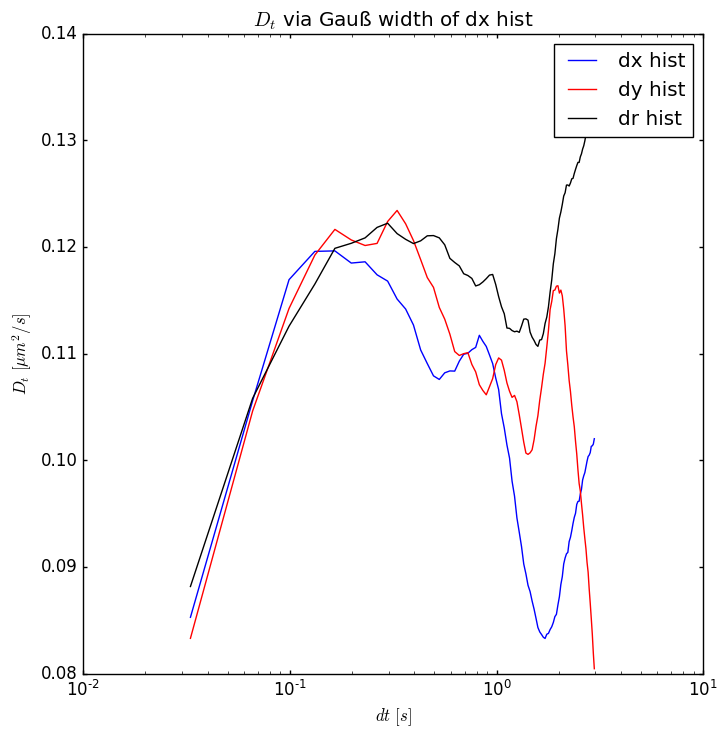

In [234]:
def Plot_Dt_of_dt_via_dx_hist():
    t1.set_index(['master_index'],drop = False,inplace = True)
    #t1_filtered = t1[(np.isfinite(np.array(t1['dy'])))
    #                ];
    t1_filtered = t1[(np.isfinite(np.array(t1['dx'])))
                     & (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 400)
                    ];
    #print(np.sum(np.isfinite(np.array(t1_filtered[quantity]))))
    #data = np.array(t1_filtered['dy'])
    
    dx_list = np.zeros(len(t1_filtered['x']))
    dy_list = np.zeros(len(t1_filtered['x']))
    dr_list = np.zeros(len(t1_filtered['x']))
    
    #N = 0
    max_dt = int(3/exposuer_time)
    dt_list = np.linspace(1,max_dt,max_dt).astype('int')
    Dt_listx = np.zeros(len(dt_list))
    Dt_listy = np.zeros(len(dt_list))
    Dt_listr = np.zeros(len(dt_list))
    for i in range(len(dt_list)):
        dt = dt_list[i]
        n = 0
        for  pid, ptraj in t1_filtered.groupby('particle'):
            if len(ptraj.x)>dt:
                x_data = (np.array(ptraj.x))
                y_data = (np.array(ptraj.y))
                dx = (x_data[dt:]-x_data[:-dt])
                dy = (y_data[dt:]-y_data[:-dt])
                dx_list[n:n+len(dx)] = dx
                dy_list[n:n+len(dx)] = dy
                dr_list[n:n+len(dx)] = np.sqrt(dx**2+dy**2)
                n += len(dx)
        datar = dr_list[dr_list!=0]
        datay = dy_list[dy_list!=0]
        datax = dx_list[dx_list!=0]
        N = len(datax)
        n_bins = 80
        histx, bin_edgesx = np.histogram(datax, density=True,bins = n_bins)
        histy, bin_edgesy = np.histogram(datay, density=True,bins = n_bins)
        histr, bin_edgesr = np.histogram(datar, density=True,bins = n_bins)
        bin_centresx = (bin_edgesx[:-1] + bin_edgesx[1:])/2
        bin_centresy = (bin_edgesy[:-1] + bin_edgesy[1:])/2
        bin_centresr = (bin_edgesr[:-1] + bin_edgesr[1:])/2
        
        # Define model function to be used to fit to the data above:
        def gauss(x, *p):
            A, mu, sigma = p
            A, mu, D = p
            #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
            return A/np.sqrt(np.pi*4*D*dt*exposuer_time*nth)*np.exp(-(x-mu)**2/(4*D*dt*exposuer_time*nth))
        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        
        def rayleigh(x,*p):
            A, D = p
            return 2*x/(4*D*dt*exposuer_time*nth)*np.exp(-x**2/(4*D*dt*exposuer_time*nth))
        p1 = [1,1]
        p0 = [0., 0.1, 1.]
        coeffx, var_matrixx = curve_fit(gauss, bin_centresx, histx, p0=p0)
        coeffy, var_matrixy = curve_fit(gauss, bin_centresy, histy, p0=p0)
        coeffr, var_matrixr = curve_fit(rayleigh, bin_centresr, histr, p0=p1)
        
        #coeff2, var_matrix = curve_fit(dphi_dist2, bin_centres, hist, p0=p1)
        #mean = coeff[1]  # write the mean innto the matrix
        Dx = np.abs(coeffx[2])
        Dy = np.abs(coeffy[2])
        Dr = np.abs(coeffr[1])
        
        Dt_listx[i] = Dx*0.117**2
        Dt_listy[i] = Dy*0.117**2
        Dt_listr[i] = Dr*0.117**2
    #mean2 = np.mean(data)
    #uncert2 = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
    
    plt.style.use('classic')
    fig = plt.figure(figsize=(8, 8),dpi = 300)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(dt_list*exposuer_time, Dt_listx,color='blue',label='dx hist')
    ax.plot(dt_list*exposuer_time, Dt_listy,color='red',label='dy hist')
    ax.plot(dt_list*exposuer_time, Dt_listr,color='black',label='dr hist')
    ax.legend()
    ax.set_xscale("log", nonposx='clip')
    #ax.grid(which='both')
    fig.patch.set_facecolor('white')
    #ax.set_xlim(left = -5, right = 5)
    plt.title('$D_t$ via Gauß width of dx hist')
    plt.xlabel('$dt$ $[s]$')
    plt.ylabel('$D_t$ $[\mu m^2 /s]$')
    ax.tick_params(axis= 'both',direction='in', length=3, width=1, colors='black')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.savefig('Dt_via_dx_hist.pdf')
    fig.show()
    return
Plot_Dt_of_dt_via_dx_hist()

10404


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


10404


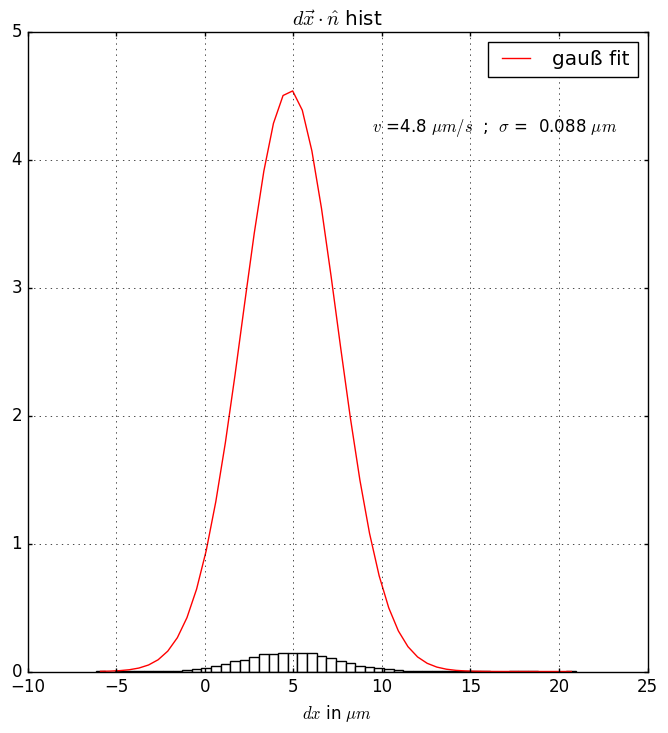

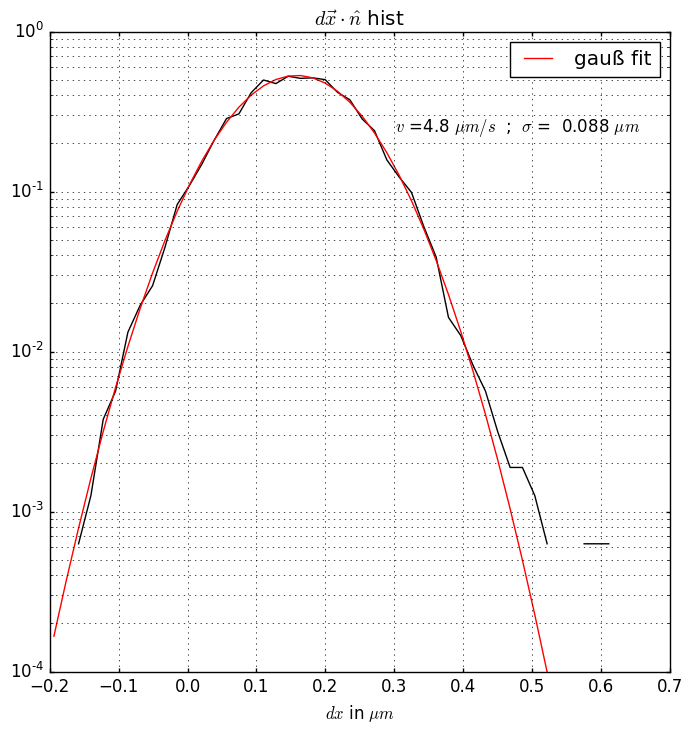

In [97]:
def Plot_quantity_WF(quantity,logy='off',unit = 1,unit_str = '2pi'):
    #t1.set_index(['master_index'],drop = False,inplace = True)
    #t1_filtered = t1[(
    #                (np.sqrt((t1['x'] - hole_x)**2 + np.sqrt(t1['y']-hole_y)**2) < 80)
    #                | ((np.sqrt((t1['x'] - center)**2 + np.sqrt(t1['y']-center)**2) > 105)
    #                   &(np.sqrt((t1['x'] - center)**2 + np.sqrt(t1['y']-center)**2) < 140))
    #                )
    #                & (np.isfinite(np.array(t1['x'])))
    #                ];
    #t1_filtered = t1[(np.isfinite(np.array(t1['dx'])))
    #                 & (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 150)
    #                ];
    t1_filtered = t_to_use[np.isfinite(t_to_use['dx'])]
    if quantity =='dr_parallel':
        dx = np.array(t1_filtered['dx'])
        dy = np.array(t1_filtered['dy'])
        phi = np.array(t1_filtered['phi'])
        data = np.zeros(len(dx))
        for k in range(len(dx)):
            data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
    else:
        data = np.array(t1_filtered[quantity])
    data = data
    N = len(data)
    print(N)
    n_bins = 50
    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [0., 0.1, 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    mean = coeff[1]  # write the mean innto the matrix
    std = np.abs(coeff[2])
    uncert = np.abs(var_matrix[1,1])
    mean2 = np.mean(data)
    uncert2 = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
    
    plt.style.use('classic')
    fig = plt.figure(figsize=(8, 8),dpi = 300)
    ax = fig.add_subplot(1, 1, 1)
    hist_fit = gauss(bin_centres, *coeff)
    #hist_fit2 = dphi_dist2(bin_centres,*coeff2)
    
    bin_size = bin_edges[1]-bin_edges[0]
    bin_edges_mid = np.array(bin_edges)+bin_size/2
    bin_edges_mid = list(bin_edges_mid)
    bin_edges_mid.pop()
    #ax.scatter(bin_edges_mid, hist)
    if logy == 'on':
        ax.semilogy(np.array(bin_edges_mid)*0.117, hist,color = 'black')
        ax.semilogy(bin_centres*0.117, hist_fit, label='gauß fit', color = 'red')
        #plt.xlim(np.min(data),np.max(data))
        plt.ylim(ymin=10**-4)
    else: 
        ax.plot(bin_centres*0.117/exposure_time, hist_fit/0.117, label='gauß fit',color = 'red')
        ax.hist(data*0.117/exposure_time,bins = n_bins,normed=True, color = 'white', ec="black")
        #ax.plot(bin_centres, hist_fit2, label = '3D rot fit')
    ax.legend()
    ax.grid(which='both')
    fig.patch.set_facecolor('white')
    #ax.set_xlim(left = -5, right = 5)
    plt.title('$d\\vec{x} \cdot \hat{n}$'+ ' hist')
    ax.text(0.75, 0.85,' $v$ =' + str(format(mean*0.117/exposure_time, '.3g'))+ ' $\mu m/s$  ;  '  
            + '$\sigma$ =  '+str(format(std*0.117, '.2g')) + ' $\mu m$'  ,
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    plt.xlabel('$dx$ in $\mu m$')
    
    ax.tick_params(axis= 'both',direction='in', length=3, width=1, colors='black')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    #ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    if logy == 'on':
        plt.savefig('dr_parallel_hist_logy_active.pdf')
    else:
        plt.savefig('dr_parallel'+'_hist_active.pdf')
    fig.show()
    return



Plot_quantity_WF('dr_parallel',logy='off',unit = 0.117,unit_str = '$\mu m s^{-1}$')
Plot_quantity_WF('dr_parallel',logy='on',unit = 0.117,unit_str = '$\mu m s^{-1}$')

In [316]:
exposuer_time

0.033

6232


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: RuntimeWarning: invalid value encountered in sqrt
C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


v_g 1.9932285059957668


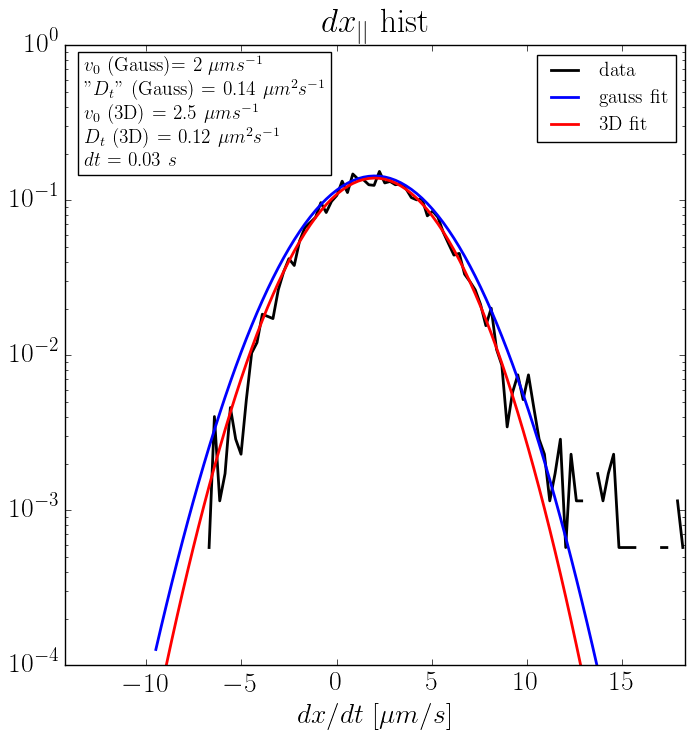

6066
v_g 2.002171336240336


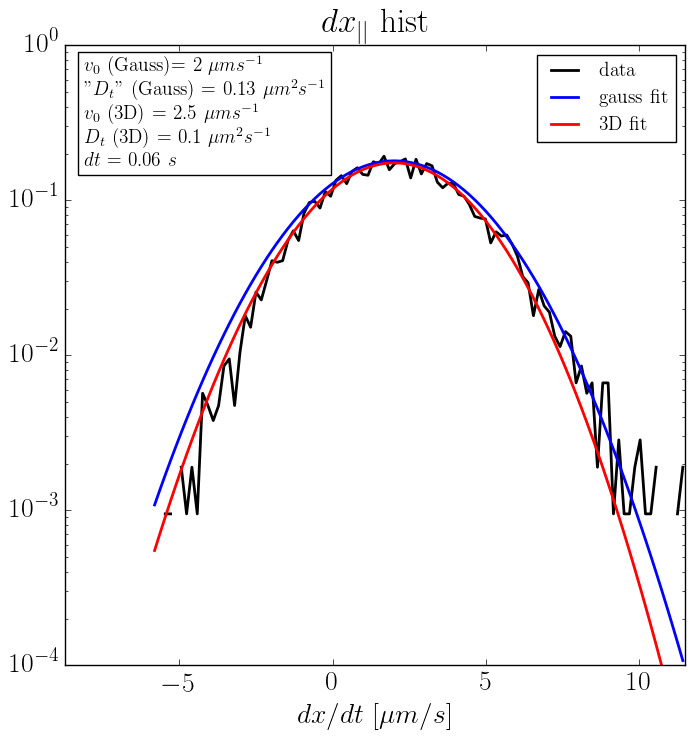

5764
v_g 1.9477972590788697


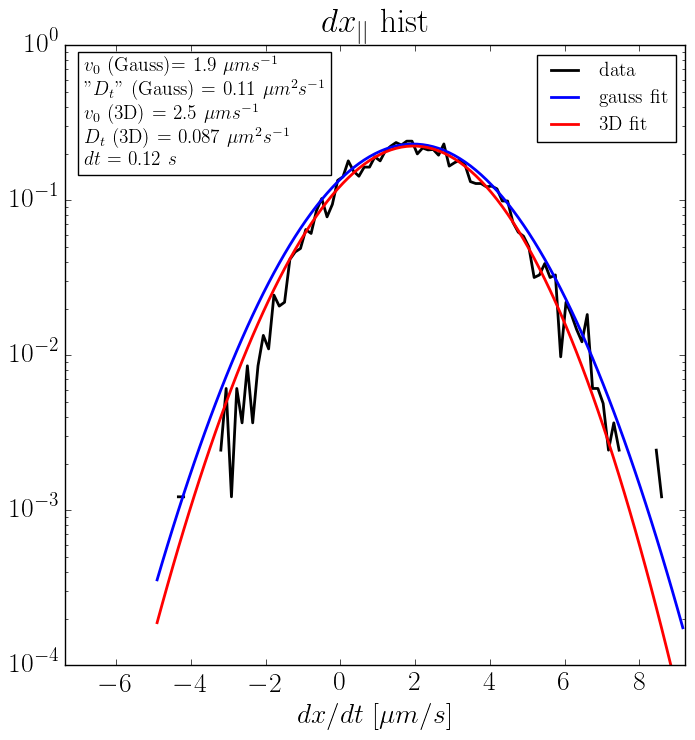

5225
v_g 1.8399820871021062


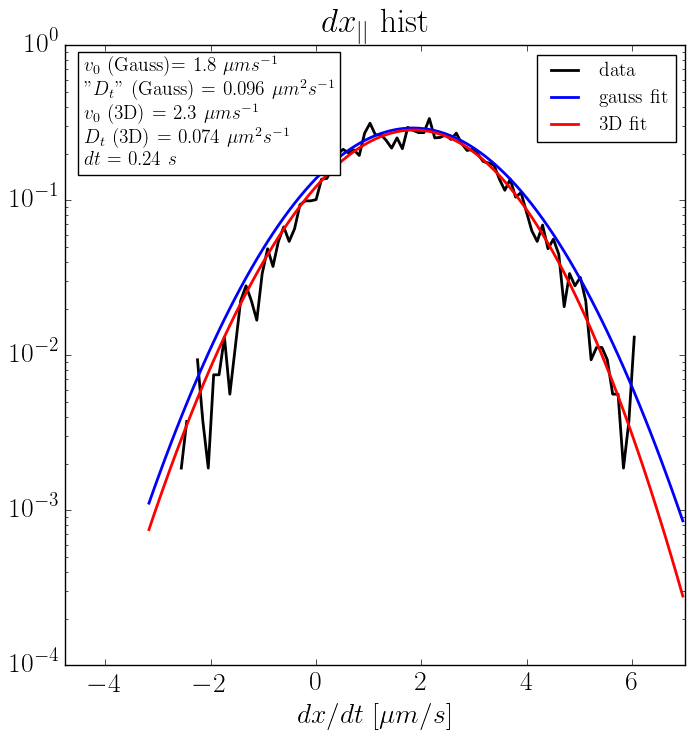

4117


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:76: RuntimeWarning: invalid value encountered in sqrt


v_g 1.5959744159411065


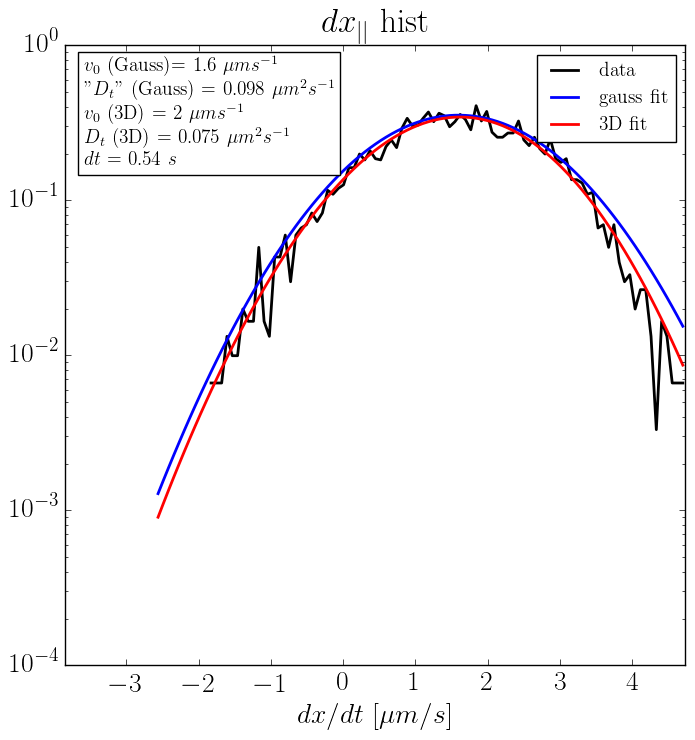

2944
v_g 1.2969639245804192


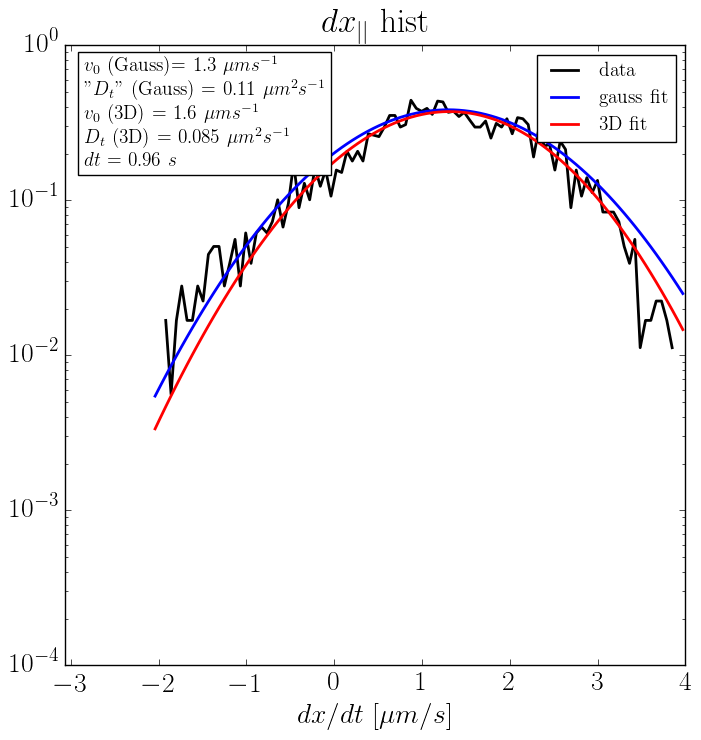

In [410]:
# plot and fit dphi
from scipy.optimize import curve_fit
def Plot_dx_parallel(logy='off',dt = 1):
    #t1.set_index(['master_index'],drop = False,inplace = True)    # some other filtering
    #t1_filtered = t1[(np.isfinite(np.array(t1['x'])))
    #                 & (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 150)
    #                ];
    #print(np.sum(np.isfinite(np.array(t1_filtered[quantity]))))
    #data = np.array(t1_filtered[quantity])
    
    #data = np.array(t_to_use['dphi'][np.isfinite(t_to_use['dphi'])])  # use the set filtering and dt =1
    
    t1_filtered = t_to_use
    #t1_filtered = t1
    
    #N = 0
    #dt = int(time_discret_factor*16/1)
    #n=0
    #phi_data = (np.array(t1_filtered.phi))[:-dt]
    #x_data = (np.array(t1_filtered.x))
    #y_data = (np.array(t1_filtered.y))
    #dx = (x_data[dt:]-x_data[:-dt])#/exposuer_time*0.117
    #dy = (y_data[dt:]-y_data[:-dt])#/exposuer_time*0.117
    #dx_parallel_list = np.cos(phi_data)*dx + np.sin(phi_data)*dy
    #data = dx_parallel_list
    #N = len(data)
    
    dx_list = np.zeros(len(t1_filtered['x']))
    dy_list = np.zeros(len(t1_filtered['x']))
    dr_parallel_list = np.zeros(len(t1_filtered['x']))
    #N = 0
    #dt = 4
    n = 0
    for  pid, ptraj in t1_filtered.groupby('particle'):
        if len(ptraj.x)>dt:
            x_data = (np.array(ptraj.x))
            y_data = (np.array(ptraj.y))
            #phi_data = (np.array(ptraj.phi))[np.isfinite(np.array(ptraj.dx))]
            phi_data = (np.array(ptraj.phi))
            dx = (x_data[dt:]-x_data[:-dt])*0.117/exposuer_time/dt
            dy = (y_data[dt:]-y_data[:-dt])*0.117/exposuer_time/dt
            #dx = np.array(ptraj.dx)[np.isfinite(np.array(ptraj.dx))]
            #dy = np.array(ptraj.dy)[np.isfinite(np.array(ptraj.dy))]
            
            dx_list[n:n+len(dx)] = dx
            dy_list[n:n+len(dx)] = dy
            dr_parallel_list[n:n+len(dx)] = -np.sin(phi_data[:-dt])*dx - np.cos(phi_data[:-dt])*dy
            n += len(dx)
    data = dr_parallel_list[dx_list!=0]

    N = len(data)
    print(N)
    n_bins = 100
    hist, bin_edges = np.histogram(data, normed=True,bins = n_bins)
    bin_centres = bin_edges[:-1] + (bin_edges[1]-bin_edges[0])/2
    
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
            #A, mu, sigma = p
            A, mu, D = p
            #return A*np.exp(-(x-mu)**2/(2.*sigma**2))
            return dt*exposure_time/np.sqrt(np.pi*4*D*dt*exposuer_time)*np.exp(-(x-mu)**2/(4*D)*dt*exposuer_time)
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    
    
    def v_hist_sperical_rot(dx,*p):
        import scipy.integrate as integrate
        D, v , A = p
        N = 100
        #D = 0.2
        #D = 0.006
        delta_t = dt*exposuer_time
        rho = 0
        for theta in np.linspace(0,np.pi,N):
            #rho +=  A* np.sin(theta)/np.sqrt(4*D*exposuretime/time_discret_factor*dt) * np.exp(-(v*np.sin(theta)-dx)**2/(4*D)*exposuretime/time_discret_factor*dt) *np.pi/N
            rho +=  A*np.sin(theta)/np.sqrt(4*D*delta_t) * np.exp(-(v*(np.sin(theta))-dx)**2/(4*D)*delta_t) *np.pi/N
        return rho
    p3 = [0.2,5,0.1]
    
    
    p0 = [1, 1, 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    v_0_gauß = coeff[1]  # write the mean innto the matrix
    #std = np.abs(coeff[1])
    D_t_gauß = coeff[2]/np.sqrt(dt)
    uncert = np.abs(var_matrix[1,1])
    
    coeff2, var_matrix2 = curve_fit(v_hist_sperical_rot, bin_centres, hist, p0=p3)
    D_t = coeff2[0] /np.sqrt(dt)
    v_0 = np.abs(coeff2[1])
    print('v_g', v_0_gauß)
    
    
    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    hist_fit = gauss(bin_centres, *coeff)
    hist_fit2 = v_hist_sperical_rot(bin_centres, *coeff2)
    #hist_soll = v_hist_sperical_rot(bin_centres, *p3)
    
    bin_size = bin_edges[1]-bin_edges[0]
    bin_edges_mid = np.array(bin_edges)+bin_size/2
    bin_edges_mid = list(bin_edges_mid)
    bin_edges_mid.pop()
    #ax.scatter(bin_edges_mid, hist)
    if logy == 'on':
        ax.semilogy(bin_edges_mid, hist,label = 'data',color='black',lw=2)
        ax.semilogy(bin_centres, hist_fit, label='gauss fit',color='blue',lw=2)
        ax.semilogy(bin_centres, hist_fit2, label='3D fit',color='red',lw=2)
        plt.xlim(np.min(data),np.max(data))
        plt.ylim(ymin=10**-4)
    else: 
        ax.plot(bin_centres, hist_fit, label='gauss fit',color='blue',lw=2)
        ax.plot(bin_centres, hist_fit2, label='3D fit',color='red',lw=2)
        #ax.plot(bin_centres, hist_soll, label='new fit',color='orange',lw=2)
        ax.hist(data,bins = n_bins,normed=True, color = 'white', ec="black",label='data')
    ax.set_xlim(xmin = bin_centres[0]*1.5)
    ax.legend(fontsize = 14)
    #ax.grid()
    plt.title('$dx_{||}$'+ ' hist')
    
    #ax.text(0.7, 0.7,'$(Gauß)$ $D_t$ =  '+str(format(std**2/2/dt*time_discret_factor, '.2g')) + ' $\mu m^2 s^{-1}$'
    #        + '\n' + '$v_0$ =  '+str(format(mean/dt*time_discret_factor, '.2g')) + ' $\mu m s^{-1}$ ' 
    #        + '\n' + '$dt$ =  '+str(format(dt*exposuretime/time_discret_factor, '.2g')) + ' $s$ ' 
    #        + '\n' + '$v_0$ (new) =  '+str(format(v_0, '.2g')) + ' $\mu m s^{-1}$ ' 
    #        + '\n' + '$D_t$ (new) =  '+str(format(D_t, '.2g')) + ' $\mu m^2 s^{-1}$ ' ,
    #     horizontalalignment='left',
    #     verticalalignment='center',
    #     bbox=dict(facecolor='w', alpha=1),
    #     transform = ax.transAxes)
    
    ax.text(0.03, 0.89,'$v_0$ (Gauss)=  '+str(format(v_0_gauß, '.2g')) + ' $\mu m s^{-1}$ '
            + '\n' +  '\"$D_t$\" (Gauss) =  '+str(format(D_t_gauß, '.2g')) + ' $\mu m^2 s^{-1}$'
            + '\n' + '$v_0$ (3D) =  '+str(format(v_0, '.2g')) + ' $\mu m s^{-1}$ ' 
            + '\n' + '$D_t$ (3D) =  '+str(format(D_t, '.2g')) + ' $\mu m^2 s^{-1}$ ' 
            + '\n' + '$dt$ =  '+str(format(dt*exposuer_time, '.2g')) + ' $s$ ',
            fontsize=14,
         horizontalalignment='left',
         verticalalignment='center',
         bbox=dict(facecolor='w', alpha=1),
         transform = ax.transAxes)
    
    
    plt.xlabel('$dx/dt$ $[\mu m /s]$') 
    
    if logy == 'on':
        plt.savefig('dx_parallel_logy_active_dt'+str(int(dt))+ '.pdf')
    else:
        plt.savefig('dx_parallel_avtive_dt' +str(int(dt))+ '.pdf')
    plt.show()
    return
#Plot_dx_parallel(logy='off',dt = 1)
Plot_dx_parallel(logy='on',dt = 1)
Plot_dx_parallel(logy='on',dt = 2)
Plot_dx_parallel(logy='on',dt = 4)
Plot_dx_parallel(logy='on',dt = 8)
Plot_dx_parallel(logy='on',dt = 18)
Plot_dx_parallel(logy='on',dt = 32)

In [ ]:
a=np.array([1,2,5,5])
b = np.array([3,4,5])
a[2:]-a[:-2]

In [339]:
file

'//192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole2/hole_25mW_rWF90_r30/1JP_expo33_nth10_2005_movie.tdms'

In [160]:
0.14 + 0.17*5.3**2/0.7

6.961857142857144

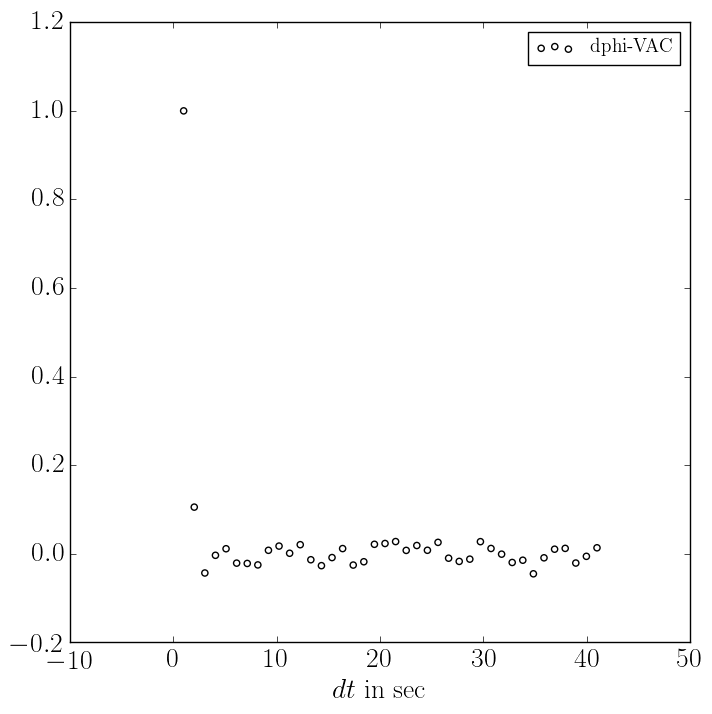

In [411]:
## velocity auto correlation VAC
def Plot_dphi_VAC():
    t1_filtered = t_to_use
    max_lagtime = 40
    VAC_list = []
    for dt in range(0,max_lagtime):
        VAC_tmp = 0
        N = 0
        u=0
        if dt==0:
            for  pid, ptraj in t1_filtered.groupby('particle'):
                if len(ptraj.phi)>dt:
                    x_data = ((np.array(ptraj.phi)))
                    #x_data = ((np.array(ptraj.phi_raw)))
                    dx_list = (x_data[1:]-x_data[:-1])
                    dx_list[dx_list<-np.pi] += np.pi*2
                    dx_list[dx_list>np.pi] += -2*np.pi
                    VAC_tmp += np.sum(dx_list[:]*dx_list[:])
                    N+=len((x_data[:]-x_data[:])[:])
        else:
            for  pid, ptraj in t1_filtered.groupby('particle'):
                if len(ptraj.phi)>dt:
                    x_data = ((np.array(ptraj.phi)))
                    #x_data = ((np.array(ptraj.phi_raw)))
                    dx_list = (x_data[1:]-x_data[:-1])
                    dx_list[dx_list<-np.pi] += np.pi*2
                    dx_list[dx_list>np.pi] += -2*np.pi
                    VAC_tmp += np.sum(dx_list[:-dt]*dx_list[dt:])
                    N+=len((x_data[1:]-x_data[:-1])[:-dt])
                    u+=1
        
        if N!=0:
            VAC_list.append(VAC_tmp/N)
    VAC_list = np.array(VAC_list/VAC_list[0])
    def expfit(x,*p):
        a, t = p
        return a*np.exp(-x/t)
    p0 = [1,1]
    #indis = (np.array(em.index)>2) & (np.array(em.index)<5)
    indis = (np.linspace(1,len(VAC_list)+1,len(VAC_list))>0) & (np.linspace(1,len(VAC_list)+1,len(VAC_list))<15)
    #t_fit = np.linspace(1,len(VAC_list),len(VAC_list))[indis]
    #coeff, var_matrix = curve_fit(expfit, np.array(range(len(VAC_list))), VAC_list, p0=p0)
    #print(t_fit)
    #print(len(VAC_list))
    #print(len(indis))
    #print(VAC_list[indis])
    #coeff, var_matrix = curve_fit(expfit, t_fit, VAC_list[indis], p0=p0)
    #tau = coeff[1]
    #f_fit = expfit(t_fit, *coeff)

    fig = plt.figure(figsize=(8, 8),dpi = 300)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(np.linspace(1,len(VAC_list)+1,len(VAC_list)), VAC_list, label='dphi-VAC', facecolors='none', edgecolors='k')
    #ax.semilogy(np.linspace(1,len(VAC_list)+1,len(VAC_list)), VAC_list, label=' VAC',color = 'black')
    #ax.semilogy(t_fit*exposure_time,f_fit,label='exp fit')
    #ax.text(0.75, 0.85,' $\tau_{corr}$ =' + str(format(tau*exposure_time, '.3g'))+ ' s',
    #     horizontalalignment='center',
    #     verticalalignment='center',
    #     transform = ax.transAxes)
    
    ax.legend(fontsize=14)
    plt.savefig('VAC_dPhi.pdf')
    plt.xlabel('$dt$ in sec')
    plt.show()
    #print('tau fit = ', tau*exposure_time)
    
    return
Plot_dphi_VAC()


0.2621353033379986


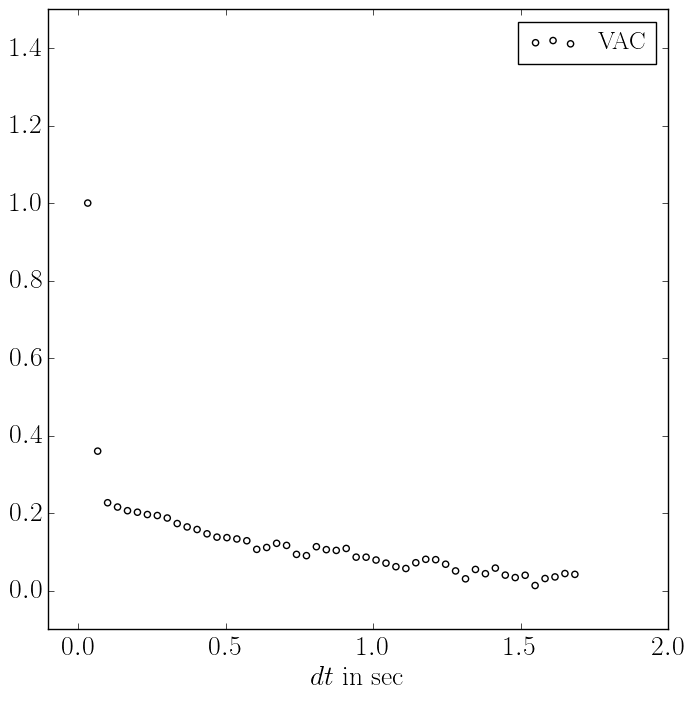

In [412]:
## velocity auto correlation VAC
def Plot_VAC():
    max_lagtime = 50
    VAC_list = []
    t1_filtered = t_to_use
    for dt in range(0,max_lagtime):
        VAC_tmp = 0
        N = 0
        if dt==0:
            for  pid, ptraj in t1_filtered.groupby('particle'):
                if len(ptraj.x)>dt:
                    x_data = (np.array(ptraj.x))
                    y_data = (np.array(ptraj.y))
                    VAC_tmp += np.sum((x_data[1:]-x_data[:-1])[:]*(x_data[1:]-x_data[:-1])[:] + (y_data[1:]-y_data[:-1])[:]*(y_data[1:]-y_data[:-1])[:])
                    N+=len((x_data[1:]-x_data[:-1])[:])
        else:
            for  pid, ptraj in t1_filtered.groupby('particle'):
                if len(ptraj.x)>dt:
                    x_data = (np.array(ptraj.x))
                    y_data = (np.array(ptraj.y))
                    VAC_tmp += np.sum((x_data[1:]-x_data[:-1])[:-dt]*(x_data[1:]-x_data[:-1])[dt:] + (y_data[1:]-y_data[:-1])[:-dt]*(y_data[1:]-y_data[:-1])[dt:])
                    N+=len((x_data[1:]-x_data[:-1])[:-dt])
        if N!=0:
            VAC_list.append(VAC_tmp/N)
    VAC_list = np.array(VAC_list/VAC_list[0])
    def expfit(x,*p):
        a, t = p
        return a*np.exp(-x/t)
    p0 = [1,1]
    #indis = (np.array(em.index)>2) & (np.array(em.index)<5)
    indis = (np.linspace(1,len(VAC_list)+1,len(VAC_list))>5) & (np.linspace(1,len(VAC_list)+1,len(VAC_list))<25)
    t_fit = np.linspace(1,len(VAC_list),len(VAC_list))[indis]
    coeff, var_matrix = curve_fit(expfit, t_fit, VAC_list[indis], p0=p0)
    print(coeff[0])
    #print(len(VAC_list))
    #print(len(indis))
    #print(VAC_list[indis])
    coeff, var_matrix = curve_fit(expfit, t_fit, VAC_list[indis], p0=p0)
    tau = coeff[1]
    f_fit = expfit(t_fit, *coeff)
    
    fig = plt.figure(figsize=(8, 8),dpi = 300)
    fig.patch.set_facecolor('white')
    #plt.rc({'axes.labelsize': 60, 'font.size': 32, 'legend.fontsize': 70.0, 'axes.titlesize': 32})
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(np.linspace(1,len(VAC_list)+1,len(VAC_list))*exposure_time, VAC_list, label='VAC',color = 'black', facecolors='none', edgecolors='k')
    #ax.plot(t_fit*exposure_time,f_fit,label='exp fit',lw=4,c='r')
    #ax.text(0.75, 0.75,' $\\tau_{corr}$ =' + str(format(tau*exposure_time, '.3g'))+ ' s',
    #        fontsize=18,
    #     horizontalalignment='left',
    #     verticalalignment='center',
    #     bbox=dict(facecolor='w', alpha=1),
    #     transform = ax.transAxes)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    
    ax.legend(fontsize = 18)
    plt.ylim(ymin = -0.1,ymax = 1.5)
    plt.xlim(xmin = -0.1)
    plt.savefig('VAC_pos_logy.pdf')
    plt.xlabel('$dt$ in sec')
    plt.show()
    #print('tau fit = ', tau*exposure_time)
    
    return
Plot_VAC()



In [126]:
exposure_time

0.04

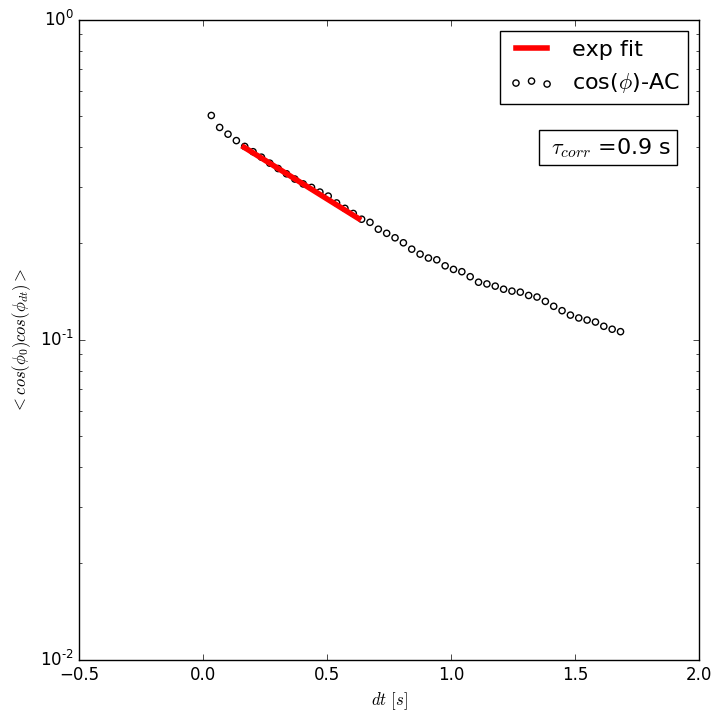

In [239]:
##  auto correlation VAC
def Plot_cos_cos_Phi_AC():
    t1_filtered = t_to_use
    max_lagtime = 50
    AC_list = []
    for dt in range(0,max_lagtime):
        AC_tmp = 0
        N = 0
        u=0
        if dt==0:
            for  pid, ptraj in t1_filtered.groupby('particle'):
                if len(ptraj.phi)>dt:
                    x_data = np.cos(np.array(ptraj.phi))
                    AC_tmp += np.sum(x_data[:]*x_data[:])
                    N+=len((x_data[:]-x_data[:])[:])
        else:
            for  pid, ptraj in t1_filtered.groupby('particle'):
                if len(ptraj.phi)>dt:
                    x_data = np.cos(np.array(ptraj.phi))
                    AC_tmp += np.sum(x_data[:-dt]*x_data[dt:])
                    N+=len((x_data[1:]-x_data[:-1])[:-dt])
                    u+=1
        
        if N!=0:
            AC_list.append(AC_tmp/N)
    AC_list = np.array(AC_list)
    def expfit(x,*p):
        a, t = p
        return a*np.exp(-x/t)
    p0 = [1,1]
    indis = (np.linspace(1,len(AC_list)+1,len(AC_list))>5) & (np.linspace(1,len(AC_list)+1,len(AC_list))<20)
    t_fit = np.linspace(1,len(AC_list),len(AC_list))[indis]
    coeff, var_matrix = curve_fit(expfit, np.array(range(len(AC_list))), AC_list, p0=p0)
    #print(t_fit)
    #print(len(VAC_list))
    #print(len(indis))
    #print(VAC_list[indis])
    coeff, var_matrix = curve_fit(expfit, t_fit, AC_list[indis], p0=p0)
    tau = coeff[1]
    f_fit = expfit(t_fit, *coeff)
    
    fig = plt.figure(figsize=(8, 8),dpi = 300)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    ax.semilogy(t_fit*exposure_time,f_fit,label='exp fit',c='red', lw = 4)
    ax.scatter(np.linspace(1,len(AC_list)+1,len(AC_list))*exposure_time, AC_list, label='cos($ \phi$)-AC', facecolors='none', edgecolors='k')
    #ax.semilogy(np.linspace(1,len(VAC_list)+1,len(VAC_list)), VAC_list, label=' VAC',color = 'black')
    
    ax.text(0.75, 0.80,' $\\tau_{corr}$ =' + str(format(tau*exposure_time, '.3g'))+ ' s',
            fontsize=16,
         horizontalalignment='left',
         verticalalignment='center',
         bbox=dict(facecolor='w', alpha=1),
         transform = ax.transAxes)
    
    ax.legend(fontsize=16)
    #plt.grid(which='both')
    plt.xlabel('$dt$ $[s]$')
    plt.ylabel('$<cos(\phi_0)cos(\phi_{dt})>$')
    plt.savefig('AC_cosPhi_logy.pdf')
    plt.show()
    #print('tau fit = ', tau*exposure_time)
    
    return
Plot_cos_cos_Phi_AC()

C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


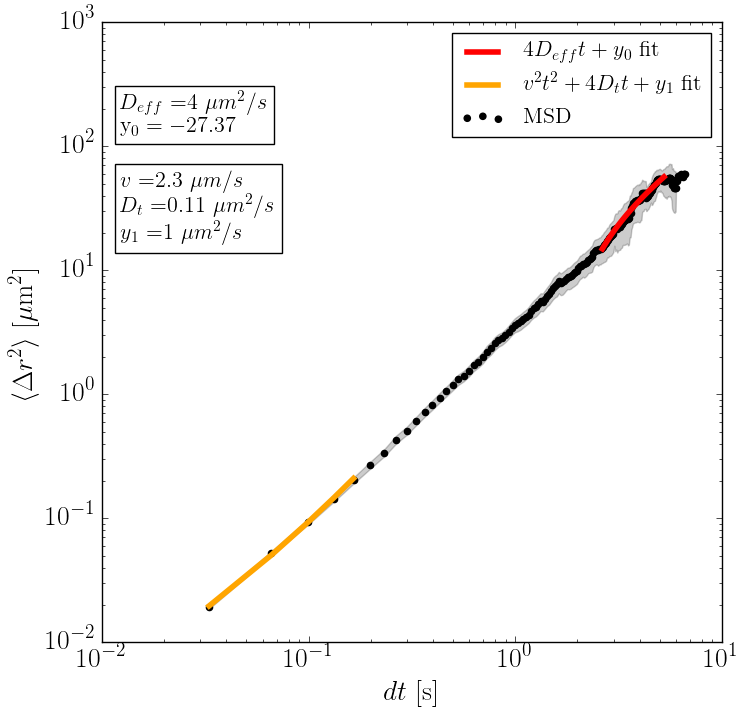

In [437]:
def Plot_MSD():
    max_lagtime = 200
    MSD_list = []
    MSD_uncert_list = []
    t1_filtered = t_to_use
    #for dt in range(1,max_lagtime):  # rolling
    #    MSD = 0
    #    N = 0
    #    for  pid, ptraj in t1_filtered.groupby('particle'):
    #        if len(ptraj.x)>dt:
    #            x_data = (np.array(ptraj.x))*0.117
    #            y_data = (np.array(ptraj.y))*0.117
    #            dx = (x_data[dt:]-x_data[:-dt])
    #            dy = (y_data[dt:]-y_data[:-dt])
    #            MSD += np.sum(dx**2 + dy**2)
    #            N+=len(dx)
    #    if N!=0:
    #        MSD_list.append(MSD/N)
            
    for dt in range(1,max_lagtime):  # stat. indipendent
        #MSD = 0
        #var_sum = 0
        #N = 0
        #for  pid, ptraj in t1_filtered.groupby('particle'):
        #    if len(ptraj.x)>dt:
        #        x_data = (np.array(ptraj.x))[::dt]*0.117
        #        y_data = (np.array(ptraj.y))[::dt]*0.117
        #        dx = (x_data[1:]-x_data[:-1])
        #        dy = (y_data[1:]-y_data[:-1])
        #        MSD += np.sum(dx**2 + dy**2)
        #        N+=len(dx)
        #if N!=0:
        #    MSD_list.append(MSD/N)
        #else:
        #    print('dt to large or somthing')
        #    break
        dx = []
        dy = []
        for  pid, ptraj in t1_filtered.groupby('particle'):
            if len(ptraj.x)>dt:
                x_data = (np.array(ptraj.x))[::dt]*0.117
                y_data = (np.array(ptraj.y))[::dt]*0.117
                dx += list((x_data[1:]-x_data[:-1]))
                dy += list((y_data[1:]-y_data[:-1]))
        dx = np.array(dx)
        dy = np.array(dy)
        MSD_list.append(np.mean(dx**2 + dy**2))
        MSD_uncert_list.append(np.std(dx**2 + dy**2)/np.sqrt(len(dx)+1)* stats.t.ppf(0.98,len(dx)))
            
    
    MSD_list = np.array(MSD_list)
    MSD_uncert_list = np.array(MSD_uncert_list)
    def linfit(x, *p):
        D, y_0 = p
        return 4*D*(x) +y_0
    p0 = [10, 10.]
    def sqfit(x,*p):
        m, x_0, y_0 = p
        return m*(x)**2
    #p2 = [1, 1, 1]
    p2 = [6,0.2,1]
    p1 = [2,1,0.1,2,1,0]
    def fit2(x,*p):
        #a,m,y_0 = p
        v ,D, y_0= p
        #D = 0
        y_0 = 0
        return v**2*x**2 + 4*D*x +y_0
    
    def theo_msd(t,*p):
        u,tau,D,alpha,b,y_0 = p
        return 4*D*t + alpha *u**2*tau**2*(b*t/tau + np.exp(-t/tau)-1)+y_0
    
    
    
    indis = (np.linspace(1,len(MSD_list)+1,len(MSD_list))>80) & (np.linspace(1,len(MSD_list)+1,len(MSD_list))<160)
    indis2 = (np.linspace(1,len(MSD_list)+1,len(MSD_list))>0) & (np.linspace(1,len(MSD_list)+1,len(MSD_list))<6)
    t_list = np.linspace(1,len(MSD_list),len(MSD_list))*exposure_time
    t_fit = np.linspace(1,len(MSD_list),len(MSD_list))[indis]
    t_fit2 = np.linspace(1,len(MSD_list),len(MSD_list))[indis2] 
    coeff, var_matrix = curve_fit(linfit, t_fit, MSD_list[indis], sigma = MSD_uncert_list[indis],absolute_sigma=True, p0=p0)
    coeff2, var_matrix2 = curve_fit(fit2, t_fit2, MSD_list[indis2], sigma = MSD_uncert_list[indis2],absolute_sigma=True, p0=p2)
    #coeff_theo, var_matrix = curve_fit(theo_msd,t_list,MSD_list,p0=p1, sigma =MSD_list,absolute_sigma=True)
    
    D_eff = coeff[0]
    v_2 = np.abs(coeff2[0])
    D_t2 = coeff2[1]
    y_01 = coeff[1]
    y_02 = coeff2[2]
    f_fit = linfit(t_fit, *coeff)
    f_fit2 = fit2(t_fit2, *coeff2)
    f_fit_sup = 4*D_eff*np.linspace(1,len(MSD_list)+1)
    #f_fit_theo = theo_msd(t_list,*[2,0.7,0.14,1])
    #f_fit_theo = theo_msd(t_list,*coeff_theo)
    #u_theo,tau_theo,D_theo,a,b,c = coeff_theo
    
    fig = plt.figure(figsize=(8, 8),dpi=300)
    fig.patch.set_facecolor('white')
    plt.rc('font', **{'family': 'serif', 'serif': ['Helvetica'],'size':20})
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(np.linspace(1,len(MSD_list)+1,len(MSD_list))*exposure_time, MSD_list, label='MSD',color = 'black')
    ax.plot(t_fit*exposure_time,f_fit,label='$4D_{eff}t +y_0$ fit',color = 'red',lw=4)
    #ax.plot(np.linspace(1,len(MSD_list)+1)*exposure_time,f_fit_sup,color = 'red',lw=2,ls='--',label='$4D_{eff}dt$')
    ax.plot(t_fit2*exposure_time,f_fit2,label='$v^2t^2+4D_tt + y_1$ fit',color = 'orange',lw=4)
    #ax.plot(t_list,f_fit_theo,label='theo',color = 'blue',lw=4)
    ax.fill_between(np.linspace(1,len(MSD_list)+1,len(MSD_list))*exposure_time, MSD_list + MSD_uncert_list, MSD_list - MSD_uncert_list,color='k', alpha = 0.2)
    ax.text(0.03, 0.85,' $D_{eff}$ =' + str(format(D_eff/exposure_time, '.3g'))+ ' $\mu m^2/ s$'
            + '\n' + ' y_0 = ' + str(format(y_01,'.2f')),
            fontsize = 16,
         horizontalalignment='left',
         verticalalignment='center',
         bbox=dict(facecolor='w', alpha=1),
         transform = ax.transAxes)
    ax.text(0.03, 0.70,' $v$ =' + str(format(v_2/exposure_time, '.2g'))+ ' $\mu m /s$'
            + '\n' + ' $D_t$ =' + str(format(D_t2/exposure_time, '.2g'))+ ' $\mu m^2 /s$'
            + '\n' + ' $y_1$ =' + str(format(y_02, '.2g'))+ ' $\mu m^2 /s$',
            fontsize = 16,
         horizontalalignment='left',
         verticalalignment='center',
         bbox=dict(facecolor='w', alpha=1),
         transform = ax.transAxes)
    
    
    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='dt in sec')
    ax.legend(loc=0,fontsize=16)
    #plt.grid(which='both')
    plt.xlabel('$dt$ [s]')
    plt.savefig('MSD_PLOT_stat_indi.pdf')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.savefig('MSD_PLOT_loglog_stat_indi.pdf')
    plt.show()
    #print('tau fit = ', tau*exposure_time)
    return
Plot_MSD()

In [365]:
plt.fill_between?

In [373]:
a = []
a+= [4,5]
a

[4, 5]

In [360]:
a = np.array([1,2,3,9,4,5,6,3,7,7,7,7,8,95,4])
da = a[1::6]-a[:-1:6]
print(len(a),len(da))
print(a[::6])
len(a)%6

15 3
[1 6 8]


3

In [385]:
file

'//192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole2/WF_ref_15mW/1JP_expo33_nth1_2803_movie.tdms'

C:\Program Files\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


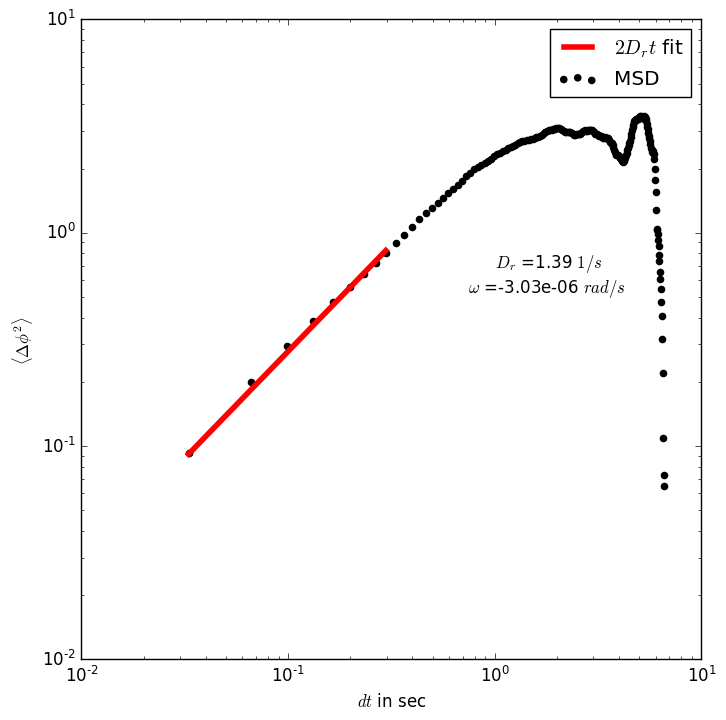

In [152]:
def Plot_phi_MSD():
    max_lagtime = 200
    MSD_list = []
    t1_filtered = t_to_use
    for dt in range(1,max_lagtime):
        MSD = 0
        N = 0
        for  pid, ptraj in t1_filtered.groupby('particle'):
            if len(ptraj.x)>dt:
                phi_data = (np.array(ptraj.phi))
                dphi_list = (phi_data[dt:]-phi_data[:-dt])
                dphi_list[dphi_list<-np.pi] += np.pi*2
                dphi_list[dphi_list>np.pi] += -2*np.pi
                MSD += np.sum(dphi_list**2)
                N+=len(dphi_list)
        if N!=0:
            MSD_list.append(MSD/N)
    MSD_list = np.array(MSD_list)
    def linfit(x, *p):
        m, x_0, y_0 = p
        return m*(x)+x_0**2*x**2
    p0 = [10, 0.01, 10.]
    def sqfit(x,*p):
        m, x_0, y_0 = p
        return m*(x)**2
    p2 = [10, 0.01, 10.]
    
    indis = (np.linspace(1,len(MSD_list)+1,len(MSD_list))>0) & (np.linspace(1,len(MSD_list)+1,len(MSD_list))<10)
    indis2 = (np.linspace(1,len(MSD_list)+1,len(MSD_list))>0) & (np.linspace(1,len(MSD_list)+1,len(MSD_list))<4)
    t_fit = np.linspace(1,len(MSD_list),len(MSD_list))[indis]
    #t_fit2 = np.linspace(1,len(MSD_list),len(MSD_list))[indis2] 
    coeff, var_matrix = curve_fit(linfit, t_fit, MSD_list[indis], p0=p0)
    #coeff2, var_matrix2 = curve_fit(sqfit, t_fit2, MSD_list[indis2], p0=p0)
    m = coeff[0]
    #m2 = coeff2[0]
    f_fit = linfit(t_fit, *coeff)
    #f_fit2 = sqfit(t_fit2, *coeff2)
    
    
    plt.style.use('classic')
    fig = plt.figure(figsize=(8, 8),dpi = 300)
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(np.linspace(1,len(MSD_list)+1,len(MSD_list))*exposure_time, MSD_list, label='MSD',color = 'black')
    ax.plot(t_fit*exposure_time,f_fit,label='$2D_{r}t$ fit',color = 'red',lw=4)
    #ax.plot(t_fit2*exposure_time,f_fit2,label='$v^2t^2+bt+y_0$ fit',color = 'blue')
    ax.text(0.75, 0.60,' $D_r$ =' + str(format(m/2/exposure_time, '.3g'))+ ' $1/ s$'
            +'\n' + '$\\omega$ =' + str(format(coeff[1], '.3g'))+ ' $rad/ s$',
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    #ax.text(0.75, 0.70,' $v_0$ =' + str(format(np.sqrt(m2/exposure_time), '.3g'))+ ' $\mu m/ s$',
    #     horizontalalignment='center',
    #     verticalalignment='center',
    #     transform = ax.transAxes)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(ylabel=r'$\langle \Delta \phi^2 \rangle$',
       xlabel='$dt$ $[s]$')
    ax.legend()
    #plt.grid(which='both')
    plt.xlabel('$dt$ in sec')
    plt.savefig('phi_MSD_PLOT.pdf')
    plt.show()
    #print('tau fit = ', tau*exposure_time)
    
    return
Plot_phi_MSD()

In [ ]:
0.18+0.17*5**2/0.7

In [ ]:
file

In [ ]:
def Plot_Orientaion(x_list,y_list,phi_list,name = ''):
    bins = 50
    x_edges = np.linspace(np.min(x_list),np.max(x_list),bins+1)
    y_edges = np.linspace(np.min(y_list),np.max(y_list),bins+1)
    x_mids = x_edges[:-1]+(x_edges[1]-x_edges[0])/2
    y_mids = y_edges[:-1]+(y_edges[1]-y_edges[0])/2
    nx_list = np.cos(phi_list)
    ny_list = np.sin(phi_list)
    N_hist = np.zeros((bins,bins))
    mean_phi_hist = np.zeros((bins,bins))
    o1_list = np.zeros((bins,bins))
    o2_list = np.zeros((bins,bins))
    o1_list_normed = np.zeros((bins,bins))
    o2_list_normed = np.zeros((bins,bins))
    o_abs_list = np.zeros((bins,bins))
    
    for i in range(bins):
        for j in range(bins):
            indis = (x_list < x_edges[i+1]) & (x_list > x_edges[i]) & (y_list < y_edges[j+1]) & (y_list > y_edges[j])
            n = np.sum(indis)
            N_hist[i,j] = n
            if n == 0:
                mean_phi_hist[i,j] = np.nan
                o1_list[i,j] = np.nan
                o2_list[i,j] = np.nan
                o1_list_normed[i,j] = np.nan
                o2_list_normed[i,j] = np.nan
                o_abs_list[i,j] = 0
            else:
                o1 = np.sum(nx_list[indis])/n
                o2 = np.sum(ny_list[indis])/n
                phi = np.arctan2(o2,o1)
                mean_phi_hist[i,j] = phi
                o1_list[i,j] = o1
                o2_list[i,j] = o2
                o1_list_normed[i,j] = np.cos(phi)
                o2_list_normed[i,j] = np.sin(phi)
                o_abs_list[i,j] = np.sqrt(o1**2+o2**2)
    plt.figure(figsize = (14,14))
    plt.title('mean phi')
    Q = plt.quiver(x_mids, y_mids,o1_list,o2_list, N_hist,units='width', cmap = 'Greys')
    plt.savefig(name + 'phi_XY_1')
    plt.show()
    
    plt.figure(figsize = (14,14))
    plt.title('mean phi')
    plt.pcolormesh(x_edges, y_edges, N_hist,cmap = 'Greys',alpha = 0.3)
    Q = plt.quiver(x_mids, y_mids,o1_list,o2_list, units='width',color = 'red')
    plt.savefig(name + 'phi_XY_2')
    plt.show()
    
    plt.figure(figsize = (14,14))
    plt.title('mean phi normed')
    plt.pcolormesh(x_edges, y_edges, N_hist,cmap = 'gray')
    Q = plt.quiver(x_mids, y_mids,o1_list_normed,o2_list_normed,o_abs_list , units='width',cmap = 'hot')
    plt.savefig('phi_XY_normed')
    plt.show()
    
    plt.figure(figsize = (14,14))
    plt.title('mean phi normed')
    plt.pcolormesh(x_edges, y_edges, o_abs_list,cmap = 'gray')
    Q = plt.quiver(x_mids, y_mids,o1_list_normed,o2_list_normed,N_hist , units='width',cmap = 'hot')
    plt.savefig(name + 'phi_XY_normed2')
    plt.show()
    
    return
Plot_Orientaion(np.array(np.array(t1.y)-255), np.array(np.array(t1.x)-255), np.array(t1.phi_raw))

def Plot_position_desity():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.figure(figsize = (10,7),dpi = 200)
    plt.hist2d(Tracked_particles['x'],Tracked_particles['y'],cmap = 'gray',bins = 300)
    plt.title('position density')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.colorbar()
    plt.savefig('XYdensity')
    plt.show()
    return
Plot_position_desity()

In [ ]:
t = tp.link_df(Tracked_particles,20,memory = 90);

In [ ]:
t1 = tp.filter_stubs(t, 70)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', Tracked_particles['particle'].nunique())
print('After:', t1['particle'].nunique())

In [ ]:
tp.plot_traj(t1)

In [ ]:
Tracked_particles.to_csv('Tracked_particles.csv')

In [ ]:
t1.to_csv('t1.csv')

In [ ]:
Plot_displacement_hist('dy',n_bins = 100,fit =True,mode = 'normal')
Plot_disp_along_phi()

In [466]:
from matplotlib_scalebar.scalebar import ScaleBar

<ipython-input-25-949175978601>:29: SyntaxWarning: name 'tmp_series' is assigned to before global declaration
  global tmp_series; tmp_series = series
<ipython-input-25-949175978601>:68: SyntaxWarning: name 'tmp_file' is assigned to before global declaration
  global tmp_file; tmp_file = file


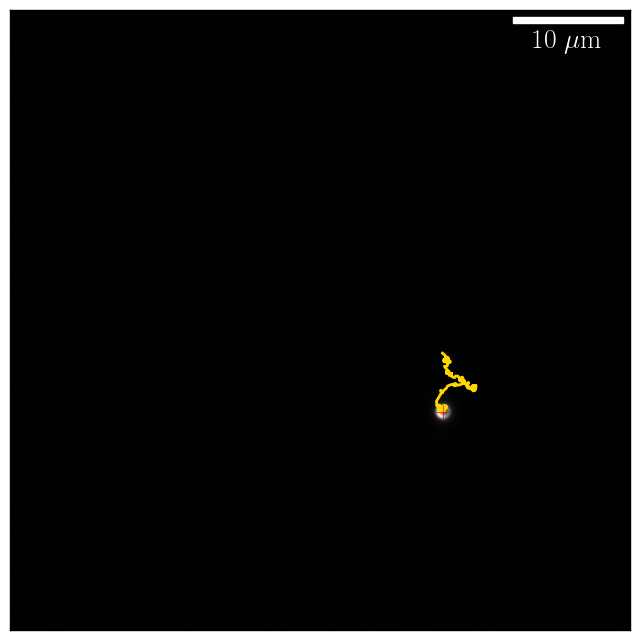

x,y =  346.0486486486486 179.5081081081081   ; frame 299   ; file  //192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole2/WF_ref_25mW2/1JP_expo33_nth1_1630_movie.tdms


In [25]:
#if 'tmp_file' in globals():
#    del tmp_file
def Show_Trajectories(particle,i,frame_buffer):
    frame = t1[t1.particle == particle].frame_rel.iat[i]
    y = t1[t1.particle == particle].y.iat[i]
    x = t1[t1.particle == particle].x.iat[i] #-"-   # something is messupo here but it works
    #plt.figure(figsize=(10,10))
    #print(type(Tracked_particles[Tracked_particles.particle == particle].file.iat[i]))
    file = t1[t1.particle == particle].file.iat[i]
    if 'tmp_file' not in globals():
        global tmp_file; tmp_file = file
        tdms_file = TdmsFile(file)
        p=tdms_file.object().properties   
        dimx=int(p['dimx'])  
        dimy=int(p['dimy'])
        frames=int(p['dimz'])
        images=tdms_file.channel_data('Image','Image')
        series = images.reshape(frames,dimx,dimy)
        global tmp_series; tmp_series = series
        print('reloaded')
    if file != tmp_file:
        tdms_file = TdmsFile(file)
        p=tdms_file.object().properties   
        dimx=int(p['dimx'])  
        dimy=int(p['dimy'])
        frames=int(p['dimz'])
        images=tdms_file.channel_data('Image','Image')
        series = images.reshape(frames,dimx,dimy)
        global tmp_series; tmp_series = series
        print('reloaded')
    #print('mean background = ', np.median(np.concatenate(tmp_series[frame+frame_buffer])))
    #plt.figure(figsize = (5,5),dpi=300)
    fig = plt.figure(figsize=(8, 8),dpi = 300)
    ax = fig.add_subplot(1, 1, 1)
    fig.patch.set_facecolor('white')
    #ax = plt.gca()
    ax.cla() # clear things for fresh plot
    
    
    
    circle1 = plt.Circle((512//2, 512//2), 120, color='r', fill=False)
    ax.imshow(tmp_series[frame+frame_buffer],cmap = 'gray')
    #ax.add_artist(circle1)
    scalebar = ScaleBar(0.117,frameon=False,color = 'white',units = 'um',height_fraction = 0.01,pad = 0.1) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    ax.plot(t1[t1.particle == particle].x,t1[t1.particle == particle].y,color = 'gold',lw = 2)
    ax.scatter(x,y,s=100,marker = '+',c='red',lw = 0.5,zorder = 10)
    
    #ax.text(0.75, 0.60,'$\Delta t$ =' + str(format(300*exposure_time, '.3g'))+ ' $s$',
    #        color = 'white',
    #     horizontalalignment='center',
    #     verticalalignment='center',
    #     transform = ax.transAxes)
    
    #a = 50
    #b = 30
    #ax.set_xlim(xmin = 130-b, xmax = 301+a )
    #ax.set_ylim(ymin = 130-b, ymax = 301+a )
    ax.set_xlim(xmin = 10, xmax = 491 )
    ax.set_ylim(ymin = 10, ymax = 491 )
    
    
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/expample_marked_particle')
    plt.savefig('example_traj_active_JP.pdf')
    plt.show()
    print('x,y = ',x,y, '  ; frame', frame, '  ; file ',file)
    global tmp_file; tmp_file = file
    return
#interact(Show_Trajectories,particle = (0,50), i = (0,500),frame_buffer = (-30,30))
Show_Trajectories(3,300-1,0)

In [484]:
file

'//192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole2/WF_ref_10mW/1JP_expo33_nth1_3151_movie.tdms'

In [ ]:
### check if dx is claced correctly  
def Show_Check_disp(p,f_rel):
    t1.set_index(['particle','frame'],drop = False,inplace = True)
    x1 = float(t1.loc[(p),['x']].iloc[f_rel])
    y1 = float(t1.loc[(p),['y']].iloc[f_rel]) #-"-   # something is messupo here but it works
    x2 = float(t1.loc[(p),['x']].iloc[f_rel+1])
    y2 = float(t1.loc[(p),['y']].iloc[f_rel+1])
    dx = float(t1.loc[(p),['dx']].iloc[f_rel+1])
    dy = float(t1.loc[(p),['dy']].iloc[f_rel+1])
    print('frame ',float(t1.loc[(p),['frame']].iloc[f_rel]),' and ',float(t1.loc[(p),['frame']].iloc[f_rel+1]))
    print('particle ',float(t1.loc[(p),['particle']].iloc[f_rel]),' and ',float(t1.loc[(p),['particle']].iloc[f_rel+1]))
    #plt.figure(figsize=(10,10))
    #print(type(Tracked_particles[Tracked_particles.particle == particle].file.iat[i]))
    plt.figure(dpi=100)
    ax = plt.gca()
    ax.cla() # clear things for fresh plot
    ax.scatter([x1,x2],[y1,y2],s=10,marker = '+',c='red',lw = 1)
    plt.title('check if the dx is claced correctly')
    ax.plot([x1,x1+dx],[y1,y1+dy])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    return
interact(Show_Check_disp,p = (0,50), f_rel = (0,40))


In [ ]:
#### calculate the fractions off particles inside and outside the box/hole
WF_box_radius_acctual = 150
PN_radius = 135
hole_radius = 0
hole_area = np.pi*hole_radius**2
center = 256-1
PN_buffer = 5
hole_x = center  ## find out if y or x
hole_y = center
WF_area = np.pi*((PN_radius-PN_buffer)**2 - (hole_radius**2))
hole_area_corrected = np.pi*(hole_radius+7)**2
def Calc_desities_tracked():
    t1.set_index(['master_index'],drop = False,inplace = True)
    hole_data = t1[(np.sqrt((t1['x'] - center)**2 + np.sqrt(t1['y']-center)**2) < hole_radius)
                     & (np.isfinite(np.array(t1['x'])))    ## here all the nans are also filtered away   # look only for pairs
                    ];
    N_hole = len(np.array(hole_data['x']))
    WF_data = t1[(np.sqrt((t1['x'] - hole_x)**2 + np.sqrt(t1['y']-hole_y)**2) > hole_radius)
                 & (np.sqrt((t1['x'] - center)**2 + np.sqrt(t1['y']-center)**2) < PN_radius-PN_buffer) # here a small spatial buffer is used to realy ignor all PN data
                 & (np.isfinite(np.array(t1['x'])))    ## here all the nans are also filtered away   # look only for pairs
                    ];
    N_WF = len(np.array(WF_data['x']))
    rho_WF = N_WF/WF_area
    rho_hole = N_hole/hole_area
    hole_data = t1
    N_whole = len(np.array(hole_data['x']))
    #print('Tracked densities')
    #print('N_hole = ',N_hole,' ; N_WF = ',N_WF, ' ; N_whole = ', N_whole, 'N_WF + N_hole = ', N_hole + N_WF)
    #print('rho_WF = ',rho_WF, ' ; rho_hole = ', rho_hole, ' ; rho_hole/rho_WF = ' ,rho_hole/rho_WF)
    fraction = rho_hole/rho_WF
    return fraction
#print(Calc_desities_tracked())


def Calc_desities_raw_image():
    I_hole = 0
    I_WF = 0
    I_rest = 0
    I_hole_corrected = 0
    I_WF_corrected = 0
    I_rest_corrected = 0
    
    mean_Background = 124
    cum_background = mean_Background*500*126
    for i in range(len(cummulated_image)):
        for j in range(len(cummulated_image)):
            if ((np.sqrt((i-center)**2+(j-center)**2) < PN_radius - PN_buffer) 
               &(np.sqrt((i-hole_x)**2+(j-hole_y)**2) > hole_radius)
               ):
                I_WF += cummulated_image[i][j]
                I_WF_corrected += cummulated_image[i][j]- cum_background
            elif ((np.sqrt((i-hole_x)**2+(j-hole_y)**2) < hole_radius) 
               ):
                I_hole += cummulated_image[i][j]
                I_hole_corrected += cummulated_image[i][j] - cum_background
            else:
                I_rest += cummulated_image[i][j]
                I_rest_corrected += cummulated_image[i][j] - cum_background
    rho_WF = I_WF/WF_area
    rho_hole = I_hole/hole_area
    rho_WF2 = I_WF_corrected/WF_area
    rho_hole2 = I_hole_corrected/hole_area
    
    #print('RAW image densities')
    #print('summ = ',int(I_hole)+int(I_WF))
    #print('I_hole = ',I_hole,' ; I_WF = ',I_WF, ' ; I_rest = ', I_rest, '  ; I_WF + I_hole = ', int(I_hole) + int(I_WF))
    #print('rho_WF = ',rho_WF, ' ; rho_hole = ', rho_hole, ' ; rho_hole/rho_WF = ' ,rho_hole/rho_WF)
    #print('corrected: ','rho_WF = ',rho_WF2, ' ; rho_hole = ', rho_hole2, ' ; rho_hole/rho_WF = ' ,rho_hole2/rho_WF2)
    return rho_hole/rho_WF
#Calc_desities_raw_image()


#Plot_quantity_WF('dphi',logy='on')   


def display_image_in_actual_size_and_analysis(image):
    fraction_tracked = Calc_desities_tracked()
    fraction_raw = Calc_desities_raw_image()
    dpi = 50
    height, width= image.shape
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)
    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    ax.imshow(image, cmap='gray',interpolation='none')
    def circle(x, y, radius=0.15,color = 'blue'):
        from matplotlib.patches import Circle
        from matplotlib.patheffects import withStroke
        circle = Circle((x, y), radius, clip_on=False, zorder=10, linewidth=1,
                        edgecolor=color, facecolor=(0, 0, 0, .0125),
                        #path_effects=[withStroke(linewidth=5, foreground='w')]
                       )
        ax.add_artist(circle)
    circle(1/2, 1/2,radius = 1/512*150,color = 'orange')
    def text(x, y, text,color = 'blue'):
        ax.text(x, y, text, backgroundcolor="white",
                ha='center', va='top', weight='bold', color=color,bbox={'facecolor':'red', 'alpha':0, 'pad':10},fontsize = 25)
    text(360, 10, r'$\frac{\rho_{inactive}}{\rho_{active}} (raw)= $' + str(format(fraction_raw, '.3g')+'$\mu m s^{-1}$'),color = 'white')
    text(380, 50, r'$\frac{\rho_{inactive}}{\rho_{active}} (tracked)= $' + str(format(fraction_tracked, '.3g')+'$\mu m s^{-1}$'),color = 'white')
    
    # Display the image.
    plt.title('cummulated_Intenstity')
    plt.savefig('cummulated_Intensity')
    plt.show()
    return 
#display_image_in_actual_size_and_analysis(cummulated_image)




In [ ]:
### look at only data within the WF and link them new, so no PN relict is in the data
#del t1_WF
t1.set_index(['master_index'],drop = False,inplace = True)

WF_data = t1[(np.isfinite(np.array(t1['dx'])))
                     & (np.sqrt(np.array(t1['x']-255)**2 + np.array(t1['y']-255)**2) < 150)
                    ];
#WF_data = t1[(np.sqrt((t1['x'] - hole_x)**2 + np.sqrt(t1['y']-hole_y)**2) > hole_radius)
#                 & (np.sqrt((t1['x'] - center)**2 + np.sqrt(t1['y']-center)**2) < PN_radius-PN_buffer) # here a small spatial buffer is used to realy ignor all PN data
#                 & (np.isfinite(np.array(t1['x'])))    ## here all the nans are also filtered away   # look only for pairs
#                    ];


t1_WF_newlylinked = tp.link_df(WF_data,15,memory = 1);

In [ ]:
im = tp.imsd(t1_WF_newlylinked,0.117,1/exposure_time,max_lagtime=2000,statistic='msd',pos_columns=None)
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$ in sec')
plt.title('single MSD')
ax.set_xscale('log')
ax.set_yscale('log')
plt.savefig('MSD_single_active')

In [ ]:
#em = tp.emsd(t1_WF_newlylinked,0.117,1/exposure_time,max_lagtime=2000,pos_columns=None)
em = tp.emsd(t1,0.117,1/exposure_time,max_lagtime=2000,pos_columns=None)
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
ax.plot(em.index, em,label = 'mean MSD',color = 'black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='dt in sec')
def linearf(x, *p):
    m, x_0, y_0 = p
    return m*(x-x_0) + y_0
p0 = [10, 0.01, 10.]


def sqfit(x,*p):
    m, x_0, y_0 = p
    return m*(x-x_0)**2- y_0
p2 = [10, 0.01, 10.]

indis = (np.array(em.index)>0.5) & (np.array(em.index)<5)
indis2 = (np.array(em.index)>0.05) & (np.array(em.index)<0.5)
coeff, var_matrix = curve_fit(linearf,em.index[indis],em[indis], p0=p0)
#coeff2, var_matrix2 = curve_fit(sqfit,em.index[indis2],em[indis2], p0=p2)
m = coeff[0]
x_0 = coeff[1]
y_0 = coeff[2]

#m_sq = coeff2[0]
#x_0_sq = coeff2[1]
#y_0_sq = coeff2[2]
#print(np.array(em)[0])
f_fit = linearf(em.index[indis], *coeff)
#f_fit2 = sqfit(em.index[indis2], *coeff2)
ax.plot(em.index[indis], f_fit, label='linear fit',color='red')
#ax.plot(em.index[indis2], f_fit2, label='quadratic fit',color='blue')
ax.text(0.75, 0.45,' $D_{eff}$ =' + str(format(m/4, '.3g'))+ ' $\mu m^2/s$ ',
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
#ax.text(0.75, 0.55,' $m_{sq}$ =' + str(format(m_sq, '.3g'))+ ' $\mu m^2/s^2$ ',
#         horizontalalignment='center',
#         verticalalignment='center',
#         transform = ax.transAxes)
#ax.text(0.75, 0.45,' $v_{active}$ =' + str(format(np.sqrt(m_sq), '.3g'))+ ' $\mu m/s$ ',
#         horizontalalignment='center',
#         verticalalignment='center',
#         transform = ax.transAxes)

#ax.set(ylim=(1e-2, 10))
ax.legend(loc=0)
plt.savefig('MSD_plot')
#print(np.array(em[(em.index >5) &(em.index<12)].index))

In [ ]:
0.14+0.17*5**2/0.7

In [ ]:
155*0.117

In [ ]:
em = tp.emsd(t1_WF_newlylinked,0.128,30,max_lagtime=500,pos_columns=None)

fig, ax = plt.subplots()
ax.plot(em.index, em,label = 'mean MSD active')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$ in sec')
def linearf(x, *p):
    m, x_0, y_0 = p
    return m*(x-x_0) + y_0
p0 = [1, 0.1, 1.]


x_list = em.index[(np.array(em.index)>1) & (np.array(em.index)>1)]
em1 = em[(np.array(em.index)>1) & (np.array(em.index)<10)]
coeff, var_matrix = curve_fit(linearf,x_list,em1, p0=p0)
m = coeff[0]
x_0 = coeff[1]
y_0 = coeff[2]
f_fit = linearf(x_list, *coeff)
ax.plot(x_list, f_fit, label='linear fit')
#ax.set(ylim=(1e-2, 10))
ax.grid()
ax.legend()
plt.savefig('MSD_mean_active')
#print(np.array(em[(em.index >5) &(em.index<12)].index))

In [ ]:

def Plot_avtive_MSD():
    lower_t = 2.5
    upper_t = 7.5
    upper_ballistic_t = 0.5
    
    
    diffusive_MSDs = np.array(em[(em.index>lower_t) &(em.index<upper_t)])
    lagtimes = np.array(em[(em.index>lower_t) &(em.index<upper_t)].index)
    ballistic_MSDs = np.array(em[(em.index>0) &(em.index<upper_ballistic_t)])
    ballistic_lagtimes = np.array(em[(em.index>0) &(em.index<upper_ballistic_t)].index)

    def linearf(x, *p):
            m, x_0, y_0 = p
            return m*(x-x_0) + y_0
    def parabula(x, *p):
            a, x_0, y_0 = p
            return a*(x-x_0)**2+y_0

    p0 = [1, 0.1, 1.]
    p02 = [1, 0.1, 1.]
    coeff, var_matrix = curve_fit(linearf,lagtimes,diffusive_MSDs, p0=p0)
    coeff_2, var_matrix2 = curve_fit(parabula,ballistic_lagtimes,ballistic_MSDs, p0=p02)
    m = coeff[0]
    x_0 = coeff[1]
    y_0 = coeff[2]

    print('parabula fit:',coeff_2)
    a = coeff_2[0]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    f_fit = linearf(lagtimes, *coeff)
    parabula_fit = parabula(ballistic_lagtimes,*coeff_2)
    ax.plot(em.index, em,label = 'msd active')
    ax.plot(lagtimes, f_fit, label='linear fit')
    ax.plot(ballistic_lagtimes, parabula_fit, label='parabolic fit',color = 'red')
    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
           xlabel='lag time $t$ in sec')
    ax.legend()
    ax.grid()
    ax.text(0.8, 0.5,'fitted $D_{eff}$ =  '+str(format(m, '.3g') + ' $ \mu^2 s^{-1}$'),
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes,fontsize = 12)
    ax.text(0.8, 0.4,'fitted $v_{active}$ =  '+str(format(np.sqrt(a), '.3g')+' $\mu m s^{-1}  $'),
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes,fontsize = 12)
    plt.savefig('MSD_mean_fitted_active')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.savefig('MSD_mean_fitted_loglog_active')
    fig.show()
    return
Plot_avtive_MSD()

In [23]:
### look at only data within the WF and link them new, so no PN relict is in the data
#del t1_WF
t1.set_index(['master_index'],drop = False,inplace = True)
hole_data = t1[(np.sqrt((t1['x'] - 255)**2 + np.sqrt(t1['y']-255)**2) <150)
                     & (np.isfinite(np.array(t1['x'])))    ## here all the nans are also filtered away   # look only for pairs
                    ];

print('len new  ', len(np.array(hole_data.y)))
print('len old  ', len(np.array(t1.y)))
t1_hole_newlylinked = tp.link_df(hole_data,15,memory = 2);

Frame 6704: 2 trajectories present


KeyboardInterrupt: 

In [ ]:
im = tp.imsd(t1_hole_newlylinked,0.128,30,max_lagtime=800,statistic='msd',pos_columns=None)
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$ in sec')
ax.set_xscale('log')
ax.set_yscale('log')
plt.savefig('MSD_single_inactive')

In [ ]:
em2 = tp.emsd(t1_WF_newlylinked,0.128,30,max_lagtime=500,pos_columns=None)
fig, ax = plt.subplots()
ax.plot(em.index, em, label = 'WF_data')
ax.plot(em2.index, em2,label = 'hole_data')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$ in sec')
#ax.set(ylim=(1e-2, 10))
ax.grid()
ax.legend()
plt.savefig('MSD_mean_compare')
#print(np.array(em[(em.index >5) &(em.index<12)].index))

In [ ]:
em2 = tp.emsd(t1_hole_newlylinked,0.128,30,max_lagtime=500,pos_columns=None)

fig, ax = plt.subplots()
ax.plot(em.index, em,label='MSD inactive')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$ in sec')
#ax.set(ylim=(1e-2, 10))
ax.legend()
ax.grid()
plt.savefig('MSD_mean_inactive')
#print(np.array(em[(em.index >5) &(em.index<12)].index))

In [ ]:
def Plot_inavtive_MSD():
    lower_t = 2
    upper_t = 7
    upper_ballistic_t = 0.5
    
    
    diffusive_MSDs = np.array(em2[(em2.index>lower_t) &(em2.index<upper_t)])
    lagtimes = np.array(em[(em2.index>lower_t) &(em2.index<upper_t)].index)
    ballistic_MSDs = np.array(em2[(em.index>0) &(em2.index<upper_ballistic_t)])
    ballistic_lagtimes = np.array(em2[(em.index>0) &(em2.index<upper_ballistic_t)].index)

    def linearf(x, *p):
            m, x_0, y_0 = p
            return m*(x-x_0) + y_0
    def parabula(x, *p):
            a, x_0, y_0 = p
            return a*(x-x_0)**2+y_0

    p0 = [1, 0.1, 1.]
    p02 = [1, 0.1, 1.]
    coeff, var_matrix = curve_fit(linearf,lagtimes,diffusive_MSDs, p0=p0)
    coeff_2, var_matrix2 = curve_fit(parabula,ballistic_lagtimes,ballistic_MSDs, p0=p02)
    m = coeff[0]
    x_0 = coeff[1]
    y_0 = coeff[2]

    print('parabula fit:',coeff_2)
    a = coeff_2[0]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    f_fit = linearf(lagtimes, *coeff)
    parabula_fit = parabula(ballistic_lagtimes,*coeff_2)
    ax.plot(em2.index, em2,label='MSD inactive')
    ax.plot(lagtimes, f_fit, label='linear fit')
    ax.plot(ballistic_lagtimes, parabula_fit, label='parabolic fit',color = 'red')
    ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
           xlabel='lag time $t$ in sec')
    ax.legend()
    ax.grid()
    ax.text(0.8, 0.5,'fitted $D_{eff}$ =  '+str(format(m, '.3g') + ' $ \mu^2 s^{-1}$'),
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes,fontsize = 12)
    ax.text(0.8, 0.4,'fitted $v_{active}$ =  '+str(format(np.sqrt(a), '.3g')+' $\mu m s^{-1}  $'),
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes,fontsize = 12)
    plt.savefig('MSD_mean_fitted_inactive')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.savefig('MSD_mean_fitted_loglog_inactive')
    fig.show()
    return
Plot_inavtive_MSD()

In [ ]:
WF_box_radius_acctual = 150
PN_radius = 135
hole_radius = 50
hole_area = np.pi*hole_radius**2
center = 256-1
PN_buffer = 5
hole_x = center  ## find out if y or x
hole_y = center
WF_area = np.pi*((PN_radius-PN_buffer)**2 - (hole_radius**2))
hole_area_corrected = np.pi*(hole_radius+7)**2
def Calc_desities_tracked():
    t1.set_index(['master_index'],drop = False,inplace = True)
    hole_data = t1[(np.sqrt((t1['x'] - center)**2 + np.sqrt(t1['y']-center)**2) < hole_radius)
                     & (np.isfinite(np.array(t1['x'])))    ## here all the nans are also filtered away   # look only for pairs
                    ];
    N_hole = len(np.array(hole_data['x']))
    WF_data = t1[(np.sqrt((t1['x'] - hole_x)**2 + np.sqrt(t1['y']-hole_y)**2) > hole_radius)
                 & (np.sqrt((t1['x'] - center)**2 + np.sqrt(t1['y']-center)**2) < PN_radius-PN_buffer) # here a small spatial buffer is used to realy ignor all PN data
                 & (np.isfinite(np.array(t1['x'])))    ## here all the nans are also filtered away   # look only for pairs
                    ];
    print(np.max(hole_data.x)-center)
    
    N_WF = len(np.array(WF_data['x']))
    rho_WF = N_WF/WF_area
    rho_hole = N_hole/hole_area
    hole_data = t1
    N_whole = len(np.array(hole_data['x']))
    #print('Tracked densities')
    #print('N_hole = ',N_hole,' ; N_WF = ',N_WF, ' ; N_whole = ', N_whole, 'N_WF + N_hole = ', N_hole + N_WF)
    #print('rho_WF = ',rho_WF, ' ; rho_hole = ', rho_hole, ' ; rho_hole/rho_WF = ' ,rho_hole/rho_WF)
    return rho_hole/rho_WF
Calc_desities_tracked()

In [ ]:
del WF_data


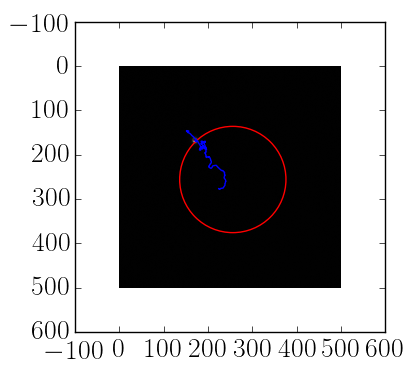

x,y =  171.03333333333333 167.51111111111112   ; frame 32   ; file  //192.168.131.72/mona/Data/Nic/Messdaten/20180207_active_passive/hole2/WF_ref_20mW/1JP_expo33_nth1_2710_movie.tdms


In [457]:
## interactive plot of image and trajectories
if 'tmp_file' in globals():
    del tmp_file
def Show_Trajectories(particle,i):
    frame = t1[t1.particle == particle].frame_rel.iat[i]
    y = t1[t1.particle == particle].y.iat[i]
    x = t1[t1.particle == particle].x.iat[i] #-"-   # something is messupo here but it works
    #plt.figure(figsize=(10,10))
    #print(type(Tracked_particles[Tracked_particles.particle == particle].file.iat[i]))
    file = t1[t1.particle == particle].file.iat[i]
    if 'tmp_file' not in globals():
        global tmp_file; tmp_file = file
        tdms_file = TdmsFile(file)
        p=tdms_file.object().properties   
        dimx=int(p['dimx'])  
        dimy=int(p['dimy'])
        frames=int(p['dimz'])
        images=tdms_file.channel_data('Image','Image')
        series = images.reshape(frames,dimx,dimy)
        global tmp_series; tmp_series = series
        print('reloaded')
    if file != tmp_file:
        tdms_file = TdmsFile(file)
        p=tdms_file.object().properties   
        dimx=int(p['dimx'])  
        dimy=int(p['dimy'])
        frames=int(p['dimz'])
        images=tdms_file.channel_data('Image','Image')
        series = images.reshape(frames,dimx,dimy)
        global tmp_series; tmp_series = series
        print('reloaded')
    plt.figure(dpi=300)
    ax = plt.gca()
    ax.cla() # clear things for fresh plot
    circle1 = plt.Circle((512//2, 512//2), 120, color='r', fill=False)
    ax.imshow(tmp_series[frame],cmap = 'gray')
    ax.scatter(x,y,s=10,marker = '+',c='red',lw = 0.5)
    ax.add_artist(circle1)
    ax.plot(t1[t1.particle == particle].x,t1[t1.particle == particle].y)
    plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/expample_marked_particle')
    plt.show()
    print('x,y = ',x,y, '  ; frame', frame, '  ; file ',file)
    global tmp_file; tmp_file = file
    return
interact(Show_Trajectories,particle = (0,50), i = (0,40))